In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from scipy.stats import pearsonr, spearmanr
import sys, os
sys.path.append('../python_scripts/')
import analysis, datasets# , baseline
sys.path.append('../imported_code/svcca/')
import cca_core, pwcca
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
import pandas as pd
from sklearn.manifold import MDS
'''
TODO: Put these in their own files
'''

# Stolen cordially from http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
'''
Plot Helpers
'''

def get_consistency_per_layer(corr_distance, num_layers=9):
    rep_consistency = np.empty(num_layers)
    for i in range(num_layers):
        square = (1 - corr_distance)[10*i:10*i+10, 10*i:10*i+10]
        up_triangle = square[np.triu_indices(n=10, k=1)]
        avg = np.mean(up_triangle)
        rep_consistency[i] = avg
        
    return rep_consistency

def plot_consistency(weights, weights_cb, shuffle, shuffle_cb, both, both_cb):
    # Get consistencies
    w = get_consistency_per_layer(weights)
    s = get_consistency_per_layer(shuffle)
    b = get_consistency_per_layer(both)
    wc = get_consistency_per_layer(weights_cb)
    sc = get_consistency_per_layer(shuffle_cb)
    bc = get_consistency_per_layer(both_cb)
    # Plot
    plt.figure(figsize=(20, 10))
    plt.title('Correlation Consistency Across Layers', fontsize=24)
    plt.plot(w, 'red', label='Weights only')
    plt.plot(wc, 'red', linestyle='dotted', label='Weights only + Cocktail Blank')
    plt.plot(s, 'cornflowerblue', label='Shuffle only')
    plt.plot(sc, 'cornflowerblue', linestyle='dotted', label='Shuffle only + Cocktail Blank')
    plt.plot(b, 'rebeccapurple', label='Weights and Shuffle')
    plt.plot(bc, 'rebeccapurple', linestyle='dotted', label='Weights and Shuffle + Cocktail Blank')
    plt.ylim(0.4, 1)
    plt.legend(fontsize=20)
    
def plot_triple_color(weights, shuffle, both, title):
    # Establish bounds for shared colorbar
    vmin = min(np.amin(weights), np.amin(shuffle), np.amin(both))
    vmax = max(np.amax(weights), np.amax(shuffle), np.amax(both))
    midpoint = vmin + vmax / 2 # Satisfy function
    norm = MidpointNormalize(midpoint=midpoint,vmin=vmin, vmax=vmax)
    # Create graphs
    cf, (cax1, cax2, cax3) = plt.subplots(1, 3)
    cf.suptitle(title, fontsize=24)
    cf.set_size_inches((20, 5.5))
    _  = color_plot_helper('Weights', weights, cax1, norm=norm)
    _  = color_plot_helper('Shuffle', shuffle, cax2, norm=norm)
    im = color_plot_helper('Both', both, cax3, norm=norm)
    # Create shared colorbar
    divider = make_axes_locatable(cax3)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(im, cax=cax)

def plot_triple_diff(weights, shuffle, both, title):
    # Create variables for readability
    bw = both - weights
    bs = both - shuffle
    ws = weights - shuffle
    # Establish bounds for shared colorbar (midpoint always 0, keep symmetric)
    _min = min(np.amin(bw), np.amin(bs), np.amin(ws))
    _max = max(np.amax(bw), np.amax(bs), np.amax(ws))
    bound = max(abs(_max), abs(_min))
    norm = MidpointNormalize(midpoint=0,vmin=-bound, vmax=bound)
    # Create graphs
    df, (dax1, dax2, dax3) = plt.subplots(1, 3)
    df.suptitle(title, fontsize=24)
    df.set_size_inches((20, 5.5))
    _  = color_plot_helper('Difference: Both - Weights', bw, dax1, norm=norm, color='seismic')
    _  = color_plot_helper('Difference: Both - Shuffle', bs, dax2, norm=norm, color='seismic')
    im = color_plot_helper('Difference: Weights - Shuffle', ws, dax3, norm=norm, color='seismic')
    # Create shared colorbar
    divider = make_axes_locatable(dax3)
    dax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(im, cax=dax)

def plot_triple_mds(weights, shuffle, both, title):
    mf, (max1, max2, max3) = plt.subplots(1, 3)
    mf.suptitle(title, fontsize=24)
    mf.set_size_inches((20, 5.5))
    mds_plot_helper('Weights', weights, max1)
    mds_plot_helper('Shuffle', shuffle, max2)
    mds_plot_helper('Both', both, max3)


def color_plot_helper(title: str, corr_distance, axis, norm=None, color=None):
    axis.set_title(title, fontsize=16)
    axis.set_xlabel('layer')
    axis.set_xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85])
    axis.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    axis.set_yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85])
    axis.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    axis.set_ylabel('layer')
    cmap = plt.get_cmap(color)
    im = axis.imshow(corr_distance, origin='upper', cmap=cmap, norm=norm)
    return im

def mds_plot_helper(title: str, corr_distance, axis):
    embedding = MDS(n_components=2, dissimilarity='precomputed')
    X_transformed = embedding.fit_transform(corr_distance)
    
    axis.set_title(title, fontsize=16)
    colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
              '#b407ed', '#7d09d6', '#50017a', '#000000']
    for i in range(10):
        axis.set(adjustable='box', aspect='equal')
        axis.plot(X_transformed[i::10, 0], X_transformed[i::10, 1], linestyle='-', color='black', zorder=1)
        axis.scatter(X_transformed[i::10, 0], X_transformed[i::10, 1], marker='o', color=colors, zorder=2)

In [9]:
'''
Get Training Stats
'''
# TODO: Clean up this code organize the notebook
def get_training_metrics(path_to_instances, testData): # testData loaded from below
    losses = []
    accs = []
    instances = os.listdir(path_to_instances)
    for instance in instances:
        # Skip any non-model files that may have snuck in
        if '.h5' not in instance:
            continue
        print(instance)
        K.clear_session()
        model = load_model(path_to_instances+instance)
        results = model.evaluate(testData.prefetch(tf.data.experimental.AUTOTUNE)\
                                 .batch(128))
        accs.append(results[1])
        
    return np.array(accs)

def get_column(accs, total):
    sr = 10/total
    _min = np.amin(accs)
    _max = np.amax(accs)
    mean = np.mean(accs)
    med = np.median(accs)
    return [_max, _min, mean, med, sr]

w_accs = get_training_metrics('../outputs/models/primary/', testData)
s_accs = get_training_metrics('../outputs/models/shuffle_seed/', testData)
b_accs = get_training_metrics('../outputs/models/both/', testData)

data = np.array([get_column(w_accs, 15),
                get_column(s_accs, 26),
                get_column(b_accs, 14)])
index = ['weights', 'shuffle', 'both']
columns = ['max acc', 'min acc', 'mean acc', 'med acc', 'success rate']

instance_303.h5
79/79 [==============================] - 1s 15ms/step - loss: 1.2462 - accuracy: 0.8443
instance_207.h5
79/79 [==============================] - 1s 13ms/step - loss: 1.2275 - accuracy: 0.8472
instance_302.h5
79/79 [==============================] - 1s 14ms/step - loss: 1.1789 - accuracy: 0.8520
instance_206.h5
79/79 [==============================] - 1s 13ms/step - loss: 1.2720 - accuracy: 0.8395
instance_305.h5
79/79 [==============================] - 1s 13ms/step - loss: 1.2275 - accuracy: 0.8460
instance_203.h5
79/79 [==============================] - 1s 14ms/step - loss: 1.2411 - accuracy: 0.8425
instance_304.h5
79/79 [==============================] - 1s 13ms/step - loss: 1.3536 - accuracy: 0.8371
instance_202.h5
79/79 [==============================] - 1s 13ms/step - loss: 1.2386 - accuracy: 0.8414
instance_200.h5
79/79 [==============================] - 1s 14ms/step - loss: 1.1990 - accuracy: 0.8477
instance_306.h5
79/79 [==============================] - 1s 13ms

In [10]:
df = pd.DataFrame(data=data, index=index, columns=columns)
df

,max acc,min acc,mean acc,med acc,success rate
weights,0.8520,0.8371,0.84430,0.84480,0.666667
shuffle,0.8445,0.8328,0.83886,0.83865,0.384615
both,0.8477,0.8342,0.84252,0.84285,0.714286


# 1. Gathering Data and Correlations

In [5]:
'''
Load Data
'''
_, testData = datasets.make_train_data(None)
x_predict, _ = datasets.make_predict_data(testData)

Making train data...
GCN...
ZCA...
Done!
Making test data...
Done!


In [98]:
'''
Calculate RSA
'''
rsa_weights = 1 - analysis.correlate('RSA', '../outputs/models/primary/', x_predict)
rsa_shuffle = 1 - analysis.correlate('RSA', '../outputs/models/shuffle_seed/', x_predict)
rsa_both = 1 - analysis.correlate('RSA', '../outputs/models/both/', x_predict)

**** Load and Preprocess Acts ****
*** Working on instance_303.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_207.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer

* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
**** Done gathering RDMs, now correlations ****
Correlation 0 , 0
Correlation 1 , 0
Correlation 1 , 1
Correlation 2 , 0
Correlation 2 , 1
Correlation 2 , 2
Correlation 3 , 0
Correlation 3 , 1
Correlation 3 , 2
Correlation 3 , 3
Correlation 4 , 0
Correlation 4 , 1
Correlation 4 , 2
Correlation 4 , 3
Correlation 4 , 4
Correlation 5 , 0
Correlation 5 , 1
Correlation 5 , 2
Correlation 5 , 3
Correlation 5 , 4
Correlation 5 , 5
Correlation 6 , 0
Correlation 6 , 1
Correlation 6 , 2
Correlation 6 , 3
Correlation 6 , 4
Correlation 6 , 5
Correlation 6 , 6
Correlation 7 , 0
Correlation 7 , 1
Correlation 7 , 2
Correlation 7 , 3
Correlation 7 , 4
Correlation 7 , 5
Correlation 7 , 6
Correlation 7 , 7
Correlation 8 , 0
Correlation 8 , 1
Correlation 8 , 2
Correlation 8 , 3
Correlation 8 , 4
Correlation 8 , 5
Correlation 8 , 6
Correlation 8 , 7
Correlation 8 , 8
Correlation 9 , 0
Correlation

Correlation 28 , 12
Correlation 28 , 13
Correlation 28 , 14
Correlation 28 , 15
Correlation 28 , 16
Correlation 28 , 17
Correlation 28 , 18
Correlation 28 , 19
Correlation 28 , 20
Correlation 28 , 21
Correlation 28 , 22
Correlation 28 , 23
Correlation 28 , 24
Correlation 28 , 25
Correlation 28 , 26
Correlation 28 , 27
Correlation 28 , 28
Correlation 29 , 0
Correlation 29 , 1
Correlation 29 , 2
Correlation 29 , 3
Correlation 29 , 4
Correlation 29 , 5
Correlation 29 , 6
Correlation 29 , 7
Correlation 29 , 8
Correlation 29 , 9
Correlation 29 , 10
Correlation 29 , 11
Correlation 29 , 12
Correlation 29 , 13
Correlation 29 , 14
Correlation 29 , 15
Correlation 29 , 16
Correlation 29 , 17
Correlation 29 , 18
Correlation 29 , 19
Correlation 29 , 20
Correlation 29 , 21
Correlation 29 , 22
Correlation 29 , 23
Correlation 29 , 24
Correlation 29 , 25
Correlation 29 , 26
Correlation 29 , 27
Correlation 29 , 28
Correlation 29 , 29
Correlation 30 , 0
Correlation 30 , 1
Correlation 30 , 2
Correlation 3

Correlation 40 , 16
Correlation 40 , 17
Correlation 40 , 18
Correlation 40 , 19
Correlation 40 , 20
Correlation 40 , 21
Correlation 40 , 22
Correlation 40 , 23
Correlation 40 , 24
Correlation 40 , 25
Correlation 40 , 26
Correlation 40 , 27
Correlation 40 , 28
Correlation 40 , 29
Correlation 40 , 30
Correlation 40 , 31
Correlation 40 , 32
Correlation 40 , 33
Correlation 40 , 34
Correlation 40 , 35
Correlation 40 , 36
Correlation 40 , 37
Correlation 40 , 38
Correlation 40 , 39
Correlation 40 , 40
Correlation 41 , 0
Correlation 41 , 1
Correlation 41 , 2
Correlation 41 , 3
Correlation 41 , 4
Correlation 41 , 5
Correlation 41 , 6
Correlation 41 , 7
Correlation 41 , 8
Correlation 41 , 9
Correlation 41 , 10
Correlation 41 , 11
Correlation 41 , 12
Correlation 41 , 13
Correlation 41 , 14
Correlation 41 , 15
Correlation 41 , 16
Correlation 41 , 17
Correlation 41 , 18
Correlation 41 , 19
Correlation 41 , 20
Correlation 41 , 21
Correlation 41 , 22
Correlation 41 , 23
Correlation 41 , 24
Correlatio

Correlation 49 , 28
Correlation 49 , 29
Correlation 49 , 30
Correlation 49 , 31
Correlation 49 , 32
Correlation 49 , 33
Correlation 49 , 34
Correlation 49 , 35
Correlation 49 , 36
Correlation 49 , 37
Correlation 49 , 38
Correlation 49 , 39
Correlation 49 , 40
Correlation 49 , 41
Correlation 49 , 42
Correlation 49 , 43
Correlation 49 , 44
Correlation 49 , 45
Correlation 49 , 46
Correlation 49 , 47
Correlation 49 , 48
Correlation 49 , 49
Correlation 50 , 0
Correlation 50 , 1
Correlation 50 , 2
Correlation 50 , 3
Correlation 50 , 4
Correlation 50 , 5
Correlation 50 , 6
Correlation 50 , 7
Correlation 50 , 8
Correlation 50 , 9
Correlation 50 , 10
Correlation 50 , 11
Correlation 50 , 12
Correlation 50 , 13
Correlation 50 , 14
Correlation 50 , 15
Correlation 50 , 16
Correlation 50 , 17
Correlation 50 , 18
Correlation 50 , 19
Correlation 50 , 20
Correlation 50 , 21
Correlation 50 , 22
Correlation 50 , 23
Correlation 50 , 24
Correlation 50 , 25
Correlation 50 , 26
Correlation 50 , 27
Correlatio

Correlation 57 , 14
Correlation 57 , 15
Correlation 57 , 16
Correlation 57 , 17
Correlation 57 , 18
Correlation 57 , 19
Correlation 57 , 20
Correlation 57 , 21
Correlation 57 , 22
Correlation 57 , 23
Correlation 57 , 24
Correlation 57 , 25
Correlation 57 , 26
Correlation 57 , 27
Correlation 57 , 28
Correlation 57 , 29
Correlation 57 , 30
Correlation 57 , 31
Correlation 57 , 32
Correlation 57 , 33
Correlation 57 , 34
Correlation 57 , 35
Correlation 57 , 36
Correlation 57 , 37
Correlation 57 , 38
Correlation 57 , 39
Correlation 57 , 40
Correlation 57 , 41
Correlation 57 , 42
Correlation 57 , 43
Correlation 57 , 44
Correlation 57 , 45
Correlation 57 , 46
Correlation 57 , 47
Correlation 57 , 48
Correlation 57 , 49
Correlation 57 , 50
Correlation 57 , 51
Correlation 57 , 52
Correlation 57 , 53
Correlation 57 , 54
Correlation 57 , 55
Correlation 57 , 56
Correlation 57 , 57
Correlation 58 , 0
Correlation 58 , 1
Correlation 58 , 2
Correlation 58 , 3
Correlation 58 , 4
Correlation 58 , 5
Correl

Correlation 64 , 4
Correlation 64 , 5
Correlation 64 , 6
Correlation 64 , 7
Correlation 64 , 8
Correlation 64 , 9
Correlation 64 , 10
Correlation 64 , 11
Correlation 64 , 12
Correlation 64 , 13
Correlation 64 , 14
Correlation 64 , 15
Correlation 64 , 16
Correlation 64 , 17
Correlation 64 , 18
Correlation 64 , 19
Correlation 64 , 20
Correlation 64 , 21
Correlation 64 , 22
Correlation 64 , 23
Correlation 64 , 24
Correlation 64 , 25
Correlation 64 , 26
Correlation 64 , 27
Correlation 64 , 28
Correlation 64 , 29
Correlation 64 , 30
Correlation 64 , 31
Correlation 64 , 32
Correlation 64 , 33
Correlation 64 , 34
Correlation 64 , 35
Correlation 64 , 36
Correlation 64 , 37
Correlation 64 , 38
Correlation 64 , 39
Correlation 64 , 40
Correlation 64 , 41
Correlation 64 , 42
Correlation 64 , 43
Correlation 64 , 44
Correlation 64 , 45
Correlation 64 , 46
Correlation 64 , 47
Correlation 64 , 48
Correlation 64 , 49
Correlation 64 , 50
Correlation 64 , 51
Correlation 64 , 52
Correlation 64 , 53
Correl

Correlation 70 , 14
Correlation 70 , 15
Correlation 70 , 16
Correlation 70 , 17
Correlation 70 , 18
Correlation 70 , 19
Correlation 70 , 20
Correlation 70 , 21
Correlation 70 , 22
Correlation 70 , 23
Correlation 70 , 24
Correlation 70 , 25
Correlation 70 , 26
Correlation 70 , 27
Correlation 70 , 28
Correlation 70 , 29
Correlation 70 , 30
Correlation 70 , 31
Correlation 70 , 32
Correlation 70 , 33
Correlation 70 , 34
Correlation 70 , 35
Correlation 70 , 36
Correlation 70 , 37
Correlation 70 , 38
Correlation 70 , 39
Correlation 70 , 40
Correlation 70 , 41
Correlation 70 , 42
Correlation 70 , 43
Correlation 70 , 44
Correlation 70 , 45
Correlation 70 , 46
Correlation 70 , 47
Correlation 70 , 48
Correlation 70 , 49
Correlation 70 , 50
Correlation 70 , 51
Correlation 70 , 52
Correlation 70 , 53
Correlation 70 , 54
Correlation 70 , 55
Correlation 70 , 56
Correlation 70 , 57
Correlation 70 , 58
Correlation 70 , 59
Correlation 70 , 60
Correlation 70 , 61
Correlation 70 , 62
Correlation 70 , 63


Correlation 75 , 65
Correlation 75 , 66
Correlation 75 , 67
Correlation 75 , 68
Correlation 75 , 69
Correlation 75 , 70
Correlation 75 , 71
Correlation 75 , 72
Correlation 75 , 73
Correlation 75 , 74
Correlation 75 , 75
Correlation 76 , 0
Correlation 76 , 1
Correlation 76 , 2
Correlation 76 , 3
Correlation 76 , 4
Correlation 76 , 5
Correlation 76 , 6
Correlation 76 , 7
Correlation 76 , 8
Correlation 76 , 9
Correlation 76 , 10
Correlation 76 , 11
Correlation 76 , 12
Correlation 76 , 13
Correlation 76 , 14
Correlation 76 , 15
Correlation 76 , 16
Correlation 76 , 17
Correlation 76 , 18
Correlation 76 , 19
Correlation 76 , 20
Correlation 76 , 21
Correlation 76 , 22
Correlation 76 , 23
Correlation 76 , 24
Correlation 76 , 25
Correlation 76 , 26
Correlation 76 , 27
Correlation 76 , 28
Correlation 76 , 29
Correlation 76 , 30
Correlation 76 , 31
Correlation 76 , 32
Correlation 76 , 33
Correlation 76 , 34
Correlation 76 , 35
Correlation 76 , 36
Correlation 76 , 37
Correlation 76 , 38
Correlatio

Correlation 81 , 11
Correlation 81 , 12
Correlation 81 , 13
Correlation 81 , 14
Correlation 81 , 15
Correlation 81 , 16
Correlation 81 , 17
Correlation 81 , 18
Correlation 81 , 19
Correlation 81 , 20
Correlation 81 , 21
Correlation 81 , 22
Correlation 81 , 23
Correlation 81 , 24
Correlation 81 , 25
Correlation 81 , 26
Correlation 81 , 27
Correlation 81 , 28
Correlation 81 , 29
Correlation 81 , 30
Correlation 81 , 31
Correlation 81 , 32
Correlation 81 , 33
Correlation 81 , 34
Correlation 81 , 35
Correlation 81 , 36
Correlation 81 , 37
Correlation 81 , 38
Correlation 81 , 39
Correlation 81 , 40
Correlation 81 , 41
Correlation 81 , 42
Correlation 81 , 43
Correlation 81 , 44
Correlation 81 , 45
Correlation 81 , 46
Correlation 81 , 47
Correlation 81 , 48
Correlation 81 , 49
Correlation 81 , 50
Correlation 81 , 51
Correlation 81 , 52
Correlation 81 , 53
Correlation 81 , 54
Correlation 81 , 55
Correlation 81 , 56
Correlation 81 , 57
Correlation 81 , 58
Correlation 81 , 59
Correlation 81 , 60


Correlation 86 , 4
Correlation 86 , 5
Correlation 86 , 6
Correlation 86 , 7
Correlation 86 , 8
Correlation 86 , 9
Correlation 86 , 10
Correlation 86 , 11
Correlation 86 , 12
Correlation 86 , 13
Correlation 86 , 14
Correlation 86 , 15
Correlation 86 , 16
Correlation 86 , 17
Correlation 86 , 18
Correlation 86 , 19
Correlation 86 , 20
Correlation 86 , 21
Correlation 86 , 22
Correlation 86 , 23
Correlation 86 , 24
Correlation 86 , 25
Correlation 86 , 26
Correlation 86 , 27
Correlation 86 , 28
Correlation 86 , 29
Correlation 86 , 30
Correlation 86 , 31
Correlation 86 , 32
Correlation 86 , 33
Correlation 86 , 34
Correlation 86 , 35
Correlation 86 , 36
Correlation 86 , 37
Correlation 86 , 38
Correlation 86 , 39
Correlation 86 , 40
Correlation 86 , 41
Correlation 86 , 42
Correlation 86 , 43
Correlation 86 , 44
Correlation 86 , 45
Correlation 86 , 46
Correlation 86 , 47
Correlation 86 , 48
Correlation 86 , 49
Correlation 86 , 50
Correlation 86 , 51
Correlation 86 , 52
Correlation 86 , 53
Correl

* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_1012.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images 

Correlation 10 , 5
Correlation 10 , 6
Correlation 10 , 7
Correlation 10 , 8
Correlation 10 , 9
Correlation 10 , 10
Correlation 11 , 0
Correlation 11 , 1
Correlation 11 , 2
Correlation 11 , 3
Correlation 11 , 4
Correlation 11 , 5
Correlation 11 , 6
Correlation 11 , 7
Correlation 11 , 8
Correlation 11 , 9
Correlation 11 , 10
Correlation 11 , 11
Correlation 12 , 0
Correlation 12 , 1
Correlation 12 , 2
Correlation 12 , 3
Correlation 12 , 4
Correlation 12 , 5
Correlation 12 , 6
Correlation 12 , 7
Correlation 12 , 8
Correlation 12 , 9
Correlation 12 , 10
Correlation 12 , 11
Correlation 12 , 12
Correlation 13 , 0
Correlation 13 , 1
Correlation 13 , 2
Correlation 13 , 3
Correlation 13 , 4
Correlation 13 , 5
Correlation 13 , 6
Correlation 13 , 7
Correlation 13 , 8
Correlation 13 , 9
Correlation 13 , 10
Correlation 13 , 11
Correlation 13 , 12
Correlation 13 , 13
Correlation 14 , 0
Correlation 14 , 1
Correlation 14 , 2
Correlation 14 , 3
Correlation 14 , 4
Correlation 14 , 5
Correlation 14 , 6
Co

Correlation 30 , 15
Correlation 30 , 16
Correlation 30 , 17
Correlation 30 , 18
Correlation 30 , 19
Correlation 30 , 20
Correlation 30 , 21
Correlation 30 , 22
Correlation 30 , 23
Correlation 30 , 24
Correlation 30 , 25
Correlation 30 , 26
Correlation 30 , 27
Correlation 30 , 28
Correlation 30 , 29
Correlation 30 , 30
Correlation 31 , 0
Correlation 31 , 1
Correlation 31 , 2
Correlation 31 , 3
Correlation 31 , 4
Correlation 31 , 5
Correlation 31 , 6
Correlation 31 , 7
Correlation 31 , 8
Correlation 31 , 9
Correlation 31 , 10
Correlation 31 , 11
Correlation 31 , 12
Correlation 31 , 13
Correlation 31 , 14
Correlation 31 , 15
Correlation 31 , 16
Correlation 31 , 17
Correlation 31 , 18
Correlation 31 , 19
Correlation 31 , 20
Correlation 31 , 21
Correlation 31 , 22
Correlation 31 , 23
Correlation 31 , 24
Correlation 31 , 25
Correlation 31 , 26
Correlation 31 , 27
Correlation 31 , 28
Correlation 31 , 29
Correlation 31 , 30
Correlation 31 , 31
Correlation 32 , 0
Correlation 32 , 1
Correlation 

Correlation 41 , 36
Correlation 41 , 37
Correlation 41 , 38
Correlation 41 , 39
Correlation 41 , 40
Correlation 41 , 41
Correlation 42 , 0
Correlation 42 , 1
Correlation 42 , 2
Correlation 42 , 3
Correlation 42 , 4
Correlation 42 , 5
Correlation 42 , 6
Correlation 42 , 7
Correlation 42 , 8
Correlation 42 , 9
Correlation 42 , 10
Correlation 42 , 11
Correlation 42 , 12
Correlation 42 , 13
Correlation 42 , 14
Correlation 42 , 15
Correlation 42 , 16
Correlation 42 , 17
Correlation 42 , 18
Correlation 42 , 19
Correlation 42 , 20
Correlation 42 , 21
Correlation 42 , 22
Correlation 42 , 23
Correlation 42 , 24
Correlation 42 , 25
Correlation 42 , 26
Correlation 42 , 27
Correlation 42 , 28
Correlation 42 , 29
Correlation 42 , 30
Correlation 42 , 31
Correlation 42 , 32
Correlation 42 , 33
Correlation 42 , 34
Correlation 42 , 35
Correlation 42 , 36
Correlation 42 , 37
Correlation 42 , 38
Correlation 42 , 39
Correlation 42 , 40
Correlation 42 , 41
Correlation 42 , 42
Correlation 43 , 0
Correlation

Correlation 50 , 41
Correlation 50 , 42
Correlation 50 , 43
Correlation 50 , 44
Correlation 50 , 45
Correlation 50 , 46
Correlation 50 , 47
Correlation 50 , 48
Correlation 50 , 49
Correlation 50 , 50
Correlation 51 , 0
Correlation 51 , 1
Correlation 51 , 2
Correlation 51 , 3
Correlation 51 , 4
Correlation 51 , 5
Correlation 51 , 6
Correlation 51 , 7
Correlation 51 , 8
Correlation 51 , 9
Correlation 51 , 10
Correlation 51 , 11
Correlation 51 , 12
Correlation 51 , 13
Correlation 51 , 14
Correlation 51 , 15
Correlation 51 , 16
Correlation 51 , 17
Correlation 51 , 18
Correlation 51 , 19
Correlation 51 , 20
Correlation 51 , 21
Correlation 51 , 22
Correlation 51 , 23
Correlation 51 , 24
Correlation 51 , 25
Correlation 51 , 26
Correlation 51 , 27
Correlation 51 , 28
Correlation 51 , 29
Correlation 51 , 30
Correlation 51 , 31
Correlation 51 , 32
Correlation 51 , 33
Correlation 51 , 34
Correlation 51 , 35
Correlation 51 , 36
Correlation 51 , 37
Correlation 51 , 38
Correlation 51 , 39
Correlatio

Correlation 58 , 21
Correlation 58 , 22
Correlation 58 , 23
Correlation 58 , 24
Correlation 58 , 25
Correlation 58 , 26
Correlation 58 , 27
Correlation 58 , 28
Correlation 58 , 29
Correlation 58 , 30
Correlation 58 , 31
Correlation 58 , 32
Correlation 58 , 33
Correlation 58 , 34
Correlation 58 , 35
Correlation 58 , 36
Correlation 58 , 37
Correlation 58 , 38
Correlation 58 , 39
Correlation 58 , 40
Correlation 58 , 41
Correlation 58 , 42
Correlation 58 , 43
Correlation 58 , 44
Correlation 58 , 45
Correlation 58 , 46
Correlation 58 , 47
Correlation 58 , 48
Correlation 58 , 49
Correlation 58 , 50
Correlation 58 , 51
Correlation 58 , 52
Correlation 58 , 53
Correlation 58 , 54
Correlation 58 , 55
Correlation 58 , 56
Correlation 58 , 57
Correlation 58 , 58
Correlation 59 , 0
Correlation 59 , 1
Correlation 59 , 2
Correlation 59 , 3
Correlation 59 , 4
Correlation 59 , 5
Correlation 59 , 6
Correlation 59 , 7
Correlation 59 , 8
Correlation 59 , 9
Correlation 59 , 10
Correlation 59 , 11
Correlatio

Correlation 65 , 3
Correlation 65 , 4
Correlation 65 , 5
Correlation 65 , 6
Correlation 65 , 7
Correlation 65 , 8
Correlation 65 , 9
Correlation 65 , 10
Correlation 65 , 11
Correlation 65 , 12
Correlation 65 , 13
Correlation 65 , 14
Correlation 65 , 15
Correlation 65 , 16
Correlation 65 , 17
Correlation 65 , 18
Correlation 65 , 19
Correlation 65 , 20
Correlation 65 , 21
Correlation 65 , 22
Correlation 65 , 23
Correlation 65 , 24
Correlation 65 , 25
Correlation 65 , 26
Correlation 65 , 27
Correlation 65 , 28
Correlation 65 , 29
Correlation 65 , 30
Correlation 65 , 31
Correlation 65 , 32
Correlation 65 , 33
Correlation 65 , 34
Correlation 65 , 35
Correlation 65 , 36
Correlation 65 , 37
Correlation 65 , 38
Correlation 65 , 39
Correlation 65 , 40
Correlation 65 , 41
Correlation 65 , 42
Correlation 65 , 43
Correlation 65 , 44
Correlation 65 , 45
Correlation 65 , 46
Correlation 65 , 47
Correlation 65 , 48
Correlation 65 , 49
Correlation 65 , 50
Correlation 65 , 51
Correlation 65 , 52
Correla

Correlation 71 , 9
Correlation 71 , 10
Correlation 71 , 11
Correlation 71 , 12
Correlation 71 , 13
Correlation 71 , 14
Correlation 71 , 15
Correlation 71 , 16
Correlation 71 , 17
Correlation 71 , 18
Correlation 71 , 19
Correlation 71 , 20
Correlation 71 , 21
Correlation 71 , 22
Correlation 71 , 23
Correlation 71 , 24
Correlation 71 , 25
Correlation 71 , 26
Correlation 71 , 27
Correlation 71 , 28
Correlation 71 , 29
Correlation 71 , 30
Correlation 71 , 31
Correlation 71 , 32
Correlation 71 , 33
Correlation 71 , 34
Correlation 71 , 35
Correlation 71 , 36
Correlation 71 , 37
Correlation 71 , 38
Correlation 71 , 39
Correlation 71 , 40
Correlation 71 , 41
Correlation 71 , 42
Correlation 71 , 43
Correlation 71 , 44
Correlation 71 , 45
Correlation 71 , 46
Correlation 71 , 47
Correlation 71 , 48
Correlation 71 , 49
Correlation 71 , 50
Correlation 71 , 51
Correlation 71 , 52
Correlation 71 , 53
Correlation 71 , 54
Correlation 71 , 55
Correlation 71 , 56
Correlation 71 , 57
Correlation 71 , 58
C

Correlation 76 , 52
Correlation 76 , 53
Correlation 76 , 54
Correlation 76 , 55
Correlation 76 , 56
Correlation 76 , 57
Correlation 76 , 58
Correlation 76 , 59
Correlation 76 , 60
Correlation 76 , 61
Correlation 76 , 62
Correlation 76 , 63
Correlation 76 , 64
Correlation 76 , 65
Correlation 76 , 66
Correlation 76 , 67
Correlation 76 , 68
Correlation 76 , 69
Correlation 76 , 70
Correlation 76 , 71
Correlation 76 , 72
Correlation 76 , 73
Correlation 76 , 74
Correlation 76 , 75
Correlation 76 , 76
Correlation 77 , 0
Correlation 77 , 1
Correlation 77 , 2
Correlation 77 , 3
Correlation 77 , 4
Correlation 77 , 5
Correlation 77 , 6
Correlation 77 , 7
Correlation 77 , 8
Correlation 77 , 9
Correlation 77 , 10
Correlation 77 , 11
Correlation 77 , 12
Correlation 77 , 13
Correlation 77 , 14
Correlation 77 , 15
Correlation 77 , 16
Correlation 77 , 17
Correlation 77 , 18
Correlation 77 , 19
Correlation 77 , 20
Correlation 77 , 21
Correlation 77 , 22
Correlation 77 , 23
Correlation 77 , 24
Correlatio

Correlation 81 , 71
Correlation 81 , 72
Correlation 81 , 73
Correlation 81 , 74
Correlation 81 , 75
Correlation 81 , 76
Correlation 81 , 77
Correlation 81 , 78
Correlation 81 , 79
Correlation 81 , 80
Correlation 81 , 81
Correlation 82 , 0
Correlation 82 , 1
Correlation 82 , 2
Correlation 82 , 3
Correlation 82 , 4
Correlation 82 , 5
Correlation 82 , 6
Correlation 82 , 7
Correlation 82 , 8
Correlation 82 , 9
Correlation 82 , 10
Correlation 82 , 11
Correlation 82 , 12
Correlation 82 , 13
Correlation 82 , 14
Correlation 82 , 15
Correlation 82 , 16
Correlation 82 , 17
Correlation 82 , 18
Correlation 82 , 19
Correlation 82 , 20
Correlation 82 , 21
Correlation 82 , 22
Correlation 82 , 23
Correlation 82 , 24
Correlation 82 , 25
Correlation 82 , 26
Correlation 82 , 27
Correlation 82 , 28
Correlation 82 , 29
Correlation 82 , 30
Correlation 82 , 31
Correlation 82 , 32
Correlation 82 , 33
Correlation 82 , 34
Correlation 82 , 35
Correlation 82 , 36
Correlation 82 , 37
Correlation 82 , 38
Correlatio

Correlation 86 , 64
Correlation 86 , 65
Correlation 86 , 66
Correlation 86 , 67
Correlation 86 , 68
Correlation 86 , 69
Correlation 86 , 70
Correlation 86 , 71
Correlation 86 , 72
Correlation 86 , 73
Correlation 86 , 74
Correlation 86 , 75
Correlation 86 , 76
Correlation 86 , 77
Correlation 86 , 78
Correlation 86 , 79
Correlation 86 , 80
Correlation 86 , 81
Correlation 86 , 82
Correlation 86 , 83
Correlation 86 , 84
Correlation 86 , 85
Correlation 86 , 86
Correlation 87 , 0
Correlation 87 , 1
Correlation 87 , 2
Correlation 87 , 3
Correlation 87 , 4
Correlation 87 , 5
Correlation 87 , 6
Correlation 87 , 7
Correlation 87 , 8
Correlation 87 , 9
Correlation 87 , 10
Correlation 87 , 11
Correlation 87 , 12
Correlation 87 , 13
Correlation 87 , 14
Correlation 87 , 15
Correlation 87 , 16
Correlation 87 , 17
Correlation 87 , 18
Correlation 87 , 19
Correlation 87 , 20
Correlation 87 , 21
Correlation 87 , 22
Correlation 87 , 23
Correlation 87 , 24
Correlation 87 , 25
Correlation 87 , 26
Correlatio

* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w212s312.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w1200s1300.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activ

Correlation 32 , 15
Correlation 32 , 16
Correlation 32 , 17
Correlation 32 , 18
Correlation 32 , 19
Correlation 32 , 20
Correlation 32 , 21
Correlation 32 , 22
Correlation 32 , 23
Correlation 32 , 24
Correlation 32 , 25
Correlation 32 , 26
Correlation 32 , 27
Correlation 32 , 28
Correlation 32 , 29
Correlation 32 , 30
Correlation 32 , 31
Correlation 32 , 32
Correlation 33 , 0
Correlation 33 , 1
Correlation 33 , 2
Correlation 33 , 3
Correlation 33 , 4
Correlation 33 , 5
Correlation 33 , 6
Correlation 33 , 7
Correlation 33 , 8
Correlation 33 , 9
Correlation 33 , 10
Correlation 33 , 11
Correlation 33 , 12
Correlation 33 , 13
Correlation 33 , 14
Correlation 33 , 15
Correlation 33 , 16
Correlation 33 , 17
Correlation 33 , 18
Correlation 33 , 19
Correlation 33 , 20
Correlation 33 , 21
Correlation 33 , 22
Correlation 33 , 23
Correlation 33 , 24
Correlation 33 , 25
Correlation 33 , 26
Correlation 33 , 27
Correlation 33 , 28
Correlation 33 , 29
Correlation 33 , 30
Correlation 33 , 31
Correlatio

Correlation 43 , 14
Correlation 43 , 15
Correlation 43 , 16
Correlation 43 , 17
Correlation 43 , 18
Correlation 43 , 19
Correlation 43 , 20
Correlation 43 , 21
Correlation 43 , 22
Correlation 43 , 23
Correlation 43 , 24
Correlation 43 , 25
Correlation 43 , 26
Correlation 43 , 27
Correlation 43 , 28
Correlation 43 , 29
Correlation 43 , 30
Correlation 43 , 31
Correlation 43 , 32
Correlation 43 , 33
Correlation 43 , 34
Correlation 43 , 35
Correlation 43 , 36
Correlation 43 , 37
Correlation 43 , 38
Correlation 43 , 39
Correlation 43 , 40
Correlation 43 , 41
Correlation 43 , 42
Correlation 43 , 43
Correlation 44 , 0
Correlation 44 , 1
Correlation 44 , 2
Correlation 44 , 3
Correlation 44 , 4
Correlation 44 , 5
Correlation 44 , 6
Correlation 44 , 7
Correlation 44 , 8
Correlation 44 , 9
Correlation 44 , 10
Correlation 44 , 11
Correlation 44 , 12
Correlation 44 , 13
Correlation 44 , 14
Correlation 44 , 15
Correlation 44 , 16
Correlation 44 , 17
Correlation 44 , 18
Correlation 44 , 19
Correlatio

Correlation 51 , 48
Correlation 51 , 49
Correlation 51 , 50
Correlation 51 , 51
Correlation 52 , 0
Correlation 52 , 1
Correlation 52 , 2
Correlation 52 , 3
Correlation 52 , 4
Correlation 52 , 5
Correlation 52 , 6
Correlation 52 , 7
Correlation 52 , 8
Correlation 52 , 9
Correlation 52 , 10
Correlation 52 , 11
Correlation 52 , 12
Correlation 52 , 13
Correlation 52 , 14
Correlation 52 , 15
Correlation 52 , 16
Correlation 52 , 17
Correlation 52 , 18
Correlation 52 , 19
Correlation 52 , 20
Correlation 52 , 21
Correlation 52 , 22
Correlation 52 , 23
Correlation 52 , 24
Correlation 52 , 25
Correlation 52 , 26
Correlation 52 , 27
Correlation 52 , 28
Correlation 52 , 29
Correlation 52 , 30
Correlation 52 , 31
Correlation 52 , 32
Correlation 52 , 33
Correlation 52 , 34
Correlation 52 , 35
Correlation 52 , 36
Correlation 52 , 37
Correlation 52 , 38
Correlation 52 , 39
Correlation 52 , 40
Correlation 52 , 41
Correlation 52 , 42
Correlation 52 , 43
Correlation 52 , 44
Correlation 52 , 45
Correlatio

Correlation 59 , 20
Correlation 59 , 21
Correlation 59 , 22
Correlation 59 , 23
Correlation 59 , 24
Correlation 59 , 25
Correlation 59 , 26
Correlation 59 , 27
Correlation 59 , 28
Correlation 59 , 29
Correlation 59 , 30
Correlation 59 , 31
Correlation 59 , 32
Correlation 59 , 33
Correlation 59 , 34
Correlation 59 , 35
Correlation 59 , 36
Correlation 59 , 37
Correlation 59 , 38
Correlation 59 , 39
Correlation 59 , 40
Correlation 59 , 41
Correlation 59 , 42
Correlation 59 , 43
Correlation 59 , 44
Correlation 59 , 45
Correlation 59 , 46
Correlation 59 , 47
Correlation 59 , 48
Correlation 59 , 49
Correlation 59 , 50
Correlation 59 , 51
Correlation 59 , 52
Correlation 59 , 53
Correlation 59 , 54
Correlation 59 , 55
Correlation 59 , 56
Correlation 59 , 57
Correlation 59 , 58
Correlation 59 , 59
Correlation 60 , 0
Correlation 60 , 1
Correlation 60 , 2
Correlation 60 , 3
Correlation 60 , 4
Correlation 60 , 5
Correlation 60 , 6
Correlation 60 , 7
Correlation 60 , 8
Correlation 60 , 9
Correlatio

Correlation 65 , 60
Correlation 65 , 61
Correlation 65 , 62
Correlation 65 , 63
Correlation 65 , 64
Correlation 65 , 65
Correlation 66 , 0
Correlation 66 , 1
Correlation 66 , 2
Correlation 66 , 3
Correlation 66 , 4
Correlation 66 , 5
Correlation 66 , 6
Correlation 66 , 7
Correlation 66 , 8
Correlation 66 , 9
Correlation 66 , 10
Correlation 66 , 11
Correlation 66 , 12
Correlation 66 , 13
Correlation 66 , 14
Correlation 66 , 15
Correlation 66 , 16
Correlation 66 , 17
Correlation 66 , 18
Correlation 66 , 19
Correlation 66 , 20
Correlation 66 , 21
Correlation 66 , 22
Correlation 66 , 23
Correlation 66 , 24
Correlation 66 , 25
Correlation 66 , 26
Correlation 66 , 27
Correlation 66 , 28
Correlation 66 , 29
Correlation 66 , 30
Correlation 66 , 31
Correlation 66 , 32
Correlation 66 , 33
Correlation 66 , 34
Correlation 66 , 35
Correlation 66 , 36
Correlation 66 , 37
Correlation 66 , 38
Correlation 66 , 39
Correlation 66 , 40
Correlation 66 , 41
Correlation 66 , 42
Correlation 66 , 43
Correlatio

Correlation 71 , 65
Correlation 71 , 66
Correlation 71 , 67
Correlation 71 , 68
Correlation 71 , 69
Correlation 71 , 70
Correlation 71 , 71
Correlation 72 , 0
Correlation 72 , 1
Correlation 72 , 2
Correlation 72 , 3
Correlation 72 , 4
Correlation 72 , 5
Correlation 72 , 6
Correlation 72 , 7
Correlation 72 , 8
Correlation 72 , 9
Correlation 72 , 10
Correlation 72 , 11
Correlation 72 , 12
Correlation 72 , 13
Correlation 72 , 14
Correlation 72 , 15
Correlation 72 , 16
Correlation 72 , 17
Correlation 72 , 18
Correlation 72 , 19
Correlation 72 , 20
Correlation 72 , 21
Correlation 72 , 22
Correlation 72 , 23
Correlation 72 , 24
Correlation 72 , 25
Correlation 72 , 26
Correlation 72 , 27
Correlation 72 , 28
Correlation 72 , 29
Correlation 72 , 30
Correlation 72 , 31
Correlation 72 , 32
Correlation 72 , 33
Correlation 72 , 34
Correlation 72 , 35
Correlation 72 , 36
Correlation 72 , 37
Correlation 72 , 38
Correlation 72 , 39
Correlation 72 , 40
Correlation 72 , 41
Correlation 72 , 42
Correlatio

Correlation 77 , 34
Correlation 77 , 35
Correlation 77 , 36
Correlation 77 , 37
Correlation 77 , 38
Correlation 77 , 39
Correlation 77 , 40
Correlation 77 , 41
Correlation 77 , 42
Correlation 77 , 43
Correlation 77 , 44
Correlation 77 , 45
Correlation 77 , 46
Correlation 77 , 47
Correlation 77 , 48
Correlation 77 , 49
Correlation 77 , 50
Correlation 77 , 51
Correlation 77 , 52
Correlation 77 , 53
Correlation 77 , 54
Correlation 77 , 55
Correlation 77 , 56
Correlation 77 , 57
Correlation 77 , 58
Correlation 77 , 59
Correlation 77 , 60
Correlation 77 , 61
Correlation 77 , 62
Correlation 77 , 63
Correlation 77 , 64
Correlation 77 , 65
Correlation 77 , 66
Correlation 77 , 67
Correlation 77 , 68
Correlation 77 , 69
Correlation 77 , 70
Correlation 77 , 71
Correlation 77 , 72
Correlation 77 , 73
Correlation 77 , 74
Correlation 77 , 75
Correlation 77 , 76
Correlation 77 , 77
Correlation 78 , 0
Correlation 78 , 1
Correlation 78 , 2
Correlation 78 , 3
Correlation 78 , 4
Correlation 78 , 5
Correl

Correlation 82 , 48
Correlation 82 , 49
Correlation 82 , 50
Correlation 82 , 51
Correlation 82 , 52
Correlation 82 , 53
Correlation 82 , 54
Correlation 82 , 55
Correlation 82 , 56
Correlation 82 , 57
Correlation 82 , 58
Correlation 82 , 59
Correlation 82 , 60
Correlation 82 , 61
Correlation 82 , 62
Correlation 82 , 63
Correlation 82 , 64
Correlation 82 , 65
Correlation 82 , 66
Correlation 82 , 67
Correlation 82 , 68
Correlation 82 , 69
Correlation 82 , 70
Correlation 82 , 71
Correlation 82 , 72
Correlation 82 , 73
Correlation 82 , 74
Correlation 82 , 75
Correlation 82 , 76
Correlation 82 , 77
Correlation 82 , 78
Correlation 82 , 79
Correlation 82 , 80
Correlation 82 , 81
Correlation 82 , 82
Correlation 83 , 0
Correlation 83 , 1
Correlation 83 , 2
Correlation 83 , 3
Correlation 83 , 4
Correlation 83 , 5
Correlation 83 , 6
Correlation 83 , 7
Correlation 83 , 8
Correlation 83 , 9
Correlation 83 , 10
Correlation 83 , 11
Correlation 83 , 12
Correlation 83 , 13
Correlation 83 , 14
Correlatio

Correlation 87 , 38
Correlation 87 , 39
Correlation 87 , 40
Correlation 87 , 41
Correlation 87 , 42
Correlation 87 , 43
Correlation 87 , 44
Correlation 87 , 45
Correlation 87 , 46
Correlation 87 , 47
Correlation 87 , 48
Correlation 87 , 49
Correlation 87 , 50
Correlation 87 , 51
Correlation 87 , 52
Correlation 87 , 53
Correlation 87 , 54
Correlation 87 , 55
Correlation 87 , 56
Correlation 87 , 57
Correlation 87 , 58
Correlation 87 , 59
Correlation 87 , 60
Correlation 87 , 61
Correlation 87 , 62
Correlation 87 , 63
Correlation 87 , 64
Correlation 87 , 65
Correlation 87 , 66
Correlation 87 , 67
Correlation 87 , 68
Correlation 87 , 69
Correlation 87 , 70
Correlation 87 , 71
Correlation 87 , 72
Correlation 87 , 73
Correlation 87 , 74
Correlation 87 , 75
Correlation 87 , 76
Correlation 87 , 77
Correlation 87 , 78
Correlation 87 , 79
Correlation 87 , 80
Correlation 87 , 81
Correlation 87 , 82
Correlation 87 , 83
Correlation 87 , 84
Correlation 87 , 85
Correlation 87 , 86
Correlation 87 , 87


In [ ]:
'''
Calculate SVCCA
'''
svcca_weights = 1 - analysis.correlate('SVCCA', '../outputs/models/primary/', x_predict)
svcca_shuffle = 1 - analysis.correlate('SVCCA', '../outputs/models/shuffle_seed/', x_predict)
svcca_both = 1 - analysis.correlate('SVCCA', '../outputs/models/both/', x_predict)

In [ ]:
'''
Calculate PWCCA
'''
pwcca_weights = 1 - analysis.correlate('PWCCA', '../outputs/models/primary/', x_predict)
pwcca_shuffle = 1 - analysis.correlate('PWCCA', '../outputs/models/shuffle_seed/', x_predict)
pwcca_both = 1 - analysis.correlate('PWCCA', '../outputs/models/both/', x_predict)

In [99]:
'''
Calculate RSA with Cocktail Blank
'''
rsa_weights_cb = 1 - analysis.correlate('RSA', '../outputs/models/primary/', x_predict, cocktail_blank=True)
rsa_shuffle_cb = 1 - analysis.correlate('RSA', '../outputs/models/shuffle_seed/', x_predict, cocktail_blank=True)
rsa_both_cb = 1 - analysis.correlate('RSA', '../outputs/models/both/', x_predict, cocktail_blank=True)

**** Load and Preprocess Acts ****
*** Working on instance_303.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_207.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer

* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
**** Done gathering RDMs, now correlations ****
Correlation 0 , 0
Correlation 1 , 0
Correlation 1 , 1
Correlation 2 , 0
Correlation 2 , 1
Correlation 2 , 2
Correlation 3 , 0
Correlation 3 , 1
Correlation 3 , 2
Correlation 3 , 3
Correlation 4 , 0
Correlation 4 , 1
Correlation 4 , 2
Correlation 4 , 3
Correlation 4 , 4
Correlation 5 , 0
Correlation 5 , 1
Correlation 5 , 2
Correlation 5 , 3
Correlation 5 , 4
Correlation 5 , 5
Correlation 6 , 0
Correlation 6 , 1
Correlation 6 , 2
Correlation 6 , 3
Correlation 6 , 4
Correlation 6 , 5
Correlation 6 , 6
Correlation 7 , 0
Correlation 7 , 1
Correlation 7 , 2
Correlation 7 , 3
Correlation 7 , 4
Correlation 7 , 5
Correlation 7 , 6
Correlation 7 , 7
Correlation 8 , 0
Correlation 8 , 1
Correlation 8 , 2
Correlation 8 , 3
Correlation 8 , 4
Correlation 8 , 5
Correlation 8 , 6
Correlation 8 , 7
Correlation 8 , 8
Correlation 9 , 0
Correlation

Correlation 28 , 14
Correlation 28 , 15
Correlation 28 , 16
Correlation 28 , 17
Correlation 28 , 18
Correlation 28 , 19
Correlation 28 , 20
Correlation 28 , 21
Correlation 28 , 22
Correlation 28 , 23
Correlation 28 , 24
Correlation 28 , 25
Correlation 28 , 26
Correlation 28 , 27
Correlation 28 , 28
Correlation 29 , 0
Correlation 29 , 1
Correlation 29 , 2
Correlation 29 , 3
Correlation 29 , 4
Correlation 29 , 5
Correlation 29 , 6
Correlation 29 , 7
Correlation 29 , 8
Correlation 29 , 9
Correlation 29 , 10
Correlation 29 , 11
Correlation 29 , 12
Correlation 29 , 13
Correlation 29 , 14
Correlation 29 , 15
Correlation 29 , 16
Correlation 29 , 17
Correlation 29 , 18
Correlation 29 , 19
Correlation 29 , 20
Correlation 29 , 21
Correlation 29 , 22
Correlation 29 , 23
Correlation 29 , 24
Correlation 29 , 25
Correlation 29 , 26
Correlation 29 , 27
Correlation 29 , 28
Correlation 29 , 29
Correlation 30 , 0
Correlation 30 , 1
Correlation 30 , 2
Correlation 30 , 3
Correlation 30 , 4
Correlation 30 

Correlation 40 , 16
Correlation 40 , 17
Correlation 40 , 18
Correlation 40 , 19
Correlation 40 , 20
Correlation 40 , 21
Correlation 40 , 22
Correlation 40 , 23
Correlation 40 , 24
Correlation 40 , 25
Correlation 40 , 26
Correlation 40 , 27
Correlation 40 , 28
Correlation 40 , 29
Correlation 40 , 30
Correlation 40 , 31
Correlation 40 , 32
Correlation 40 , 33
Correlation 40 , 34
Correlation 40 , 35
Correlation 40 , 36
Correlation 40 , 37
Correlation 40 , 38
Correlation 40 , 39
Correlation 40 , 40
Correlation 41 , 0
Correlation 41 , 1
Correlation 41 , 2
Correlation 41 , 3
Correlation 41 , 4
Correlation 41 , 5
Correlation 41 , 6
Correlation 41 , 7
Correlation 41 , 8
Correlation 41 , 9
Correlation 41 , 10
Correlation 41 , 11
Correlation 41 , 12
Correlation 41 , 13
Correlation 41 , 14
Correlation 41 , 15
Correlation 41 , 16
Correlation 41 , 17
Correlation 41 , 18
Correlation 41 , 19
Correlation 41 , 20
Correlation 41 , 21
Correlation 41 , 22
Correlation 41 , 23
Correlation 41 , 24
Correlatio

Correlation 49 , 27
Correlation 49 , 28
Correlation 49 , 29
Correlation 49 , 30
Correlation 49 , 31
Correlation 49 , 32
Correlation 49 , 33
Correlation 49 , 34
Correlation 49 , 35
Correlation 49 , 36
Correlation 49 , 37
Correlation 49 , 38
Correlation 49 , 39
Correlation 49 , 40
Correlation 49 , 41
Correlation 49 , 42
Correlation 49 , 43
Correlation 49 , 44
Correlation 49 , 45
Correlation 49 , 46
Correlation 49 , 47
Correlation 49 , 48
Correlation 49 , 49
Correlation 50 , 0
Correlation 50 , 1
Correlation 50 , 2
Correlation 50 , 3
Correlation 50 , 4
Correlation 50 , 5
Correlation 50 , 6
Correlation 50 , 7
Correlation 50 , 8
Correlation 50 , 9
Correlation 50 , 10
Correlation 50 , 11
Correlation 50 , 12
Correlation 50 , 13
Correlation 50 , 14
Correlation 50 , 15
Correlation 50 , 16
Correlation 50 , 17
Correlation 50 , 18
Correlation 50 , 19
Correlation 50 , 20
Correlation 50 , 21
Correlation 50 , 22
Correlation 50 , 23
Correlation 50 , 24
Correlation 50 , 25
Correlation 50 , 26
Correlatio

Correlation 57 , 14
Correlation 57 , 15
Correlation 57 , 16
Correlation 57 , 17
Correlation 57 , 18
Correlation 57 , 19
Correlation 57 , 20
Correlation 57 , 21
Correlation 57 , 22
Correlation 57 , 23
Correlation 57 , 24
Correlation 57 , 25
Correlation 57 , 26
Correlation 57 , 27
Correlation 57 , 28
Correlation 57 , 29
Correlation 57 , 30
Correlation 57 , 31
Correlation 57 , 32
Correlation 57 , 33
Correlation 57 , 34
Correlation 57 , 35
Correlation 57 , 36
Correlation 57 , 37
Correlation 57 , 38
Correlation 57 , 39
Correlation 57 , 40
Correlation 57 , 41
Correlation 57 , 42
Correlation 57 , 43
Correlation 57 , 44
Correlation 57 , 45
Correlation 57 , 46
Correlation 57 , 47
Correlation 57 , 48
Correlation 57 , 49
Correlation 57 , 50
Correlation 57 , 51
Correlation 57 , 52
Correlation 57 , 53
Correlation 57 , 54
Correlation 57 , 55
Correlation 57 , 56
Correlation 57 , 57
Correlation 58 , 0
Correlation 58 , 1
Correlation 58 , 2
Correlation 58 , 3
Correlation 58 , 4
Correlation 58 , 5
Correl

Correlation 64 , 0
Correlation 64 , 1
Correlation 64 , 2
Correlation 64 , 3
Correlation 64 , 4
Correlation 64 , 5
Correlation 64 , 6
Correlation 64 , 7
Correlation 64 , 8
Correlation 64 , 9
Correlation 64 , 10
Correlation 64 , 11
Correlation 64 , 12
Correlation 64 , 13
Correlation 64 , 14
Correlation 64 , 15
Correlation 64 , 16
Correlation 64 , 17
Correlation 64 , 18
Correlation 64 , 19
Correlation 64 , 20
Correlation 64 , 21
Correlation 64 , 22
Correlation 64 , 23
Correlation 64 , 24
Correlation 64 , 25
Correlation 64 , 26
Correlation 64 , 27
Correlation 64 , 28
Correlation 64 , 29
Correlation 64 , 30
Correlation 64 , 31
Correlation 64 , 32
Correlation 64 , 33
Correlation 64 , 34
Correlation 64 , 35
Correlation 64 , 36
Correlation 64 , 37
Correlation 64 , 38
Correlation 64 , 39
Correlation 64 , 40
Correlation 64 , 41
Correlation 64 , 42
Correlation 64 , 43
Correlation 64 , 44
Correlation 64 , 45
Correlation 64 , 46
Correlation 64 , 47
Correlation 64 , 48
Correlation 64 , 49
Correlatio

Correlation 70 , 12
Correlation 70 , 13
Correlation 70 , 14
Correlation 70 , 15
Correlation 70 , 16
Correlation 70 , 17
Correlation 70 , 18
Correlation 70 , 19
Correlation 70 , 20
Correlation 70 , 21
Correlation 70 , 22
Correlation 70 , 23
Correlation 70 , 24
Correlation 70 , 25
Correlation 70 , 26
Correlation 70 , 27
Correlation 70 , 28
Correlation 70 , 29
Correlation 70 , 30
Correlation 70 , 31
Correlation 70 , 32
Correlation 70 , 33
Correlation 70 , 34
Correlation 70 , 35
Correlation 70 , 36
Correlation 70 , 37
Correlation 70 , 38
Correlation 70 , 39
Correlation 70 , 40
Correlation 70 , 41
Correlation 70 , 42
Correlation 70 , 43
Correlation 70 , 44
Correlation 70 , 45
Correlation 70 , 46
Correlation 70 , 47
Correlation 70 , 48
Correlation 70 , 49
Correlation 70 , 50
Correlation 70 , 51
Correlation 70 , 52
Correlation 70 , 53
Correlation 70 , 54
Correlation 70 , 55
Correlation 70 , 56
Correlation 70 , 57
Correlation 70 , 58
Correlation 70 , 59
Correlation 70 , 60
Correlation 70 , 61


Correlation 75 , 64
Correlation 75 , 65
Correlation 75 , 66
Correlation 75 , 67
Correlation 75 , 68
Correlation 75 , 69
Correlation 75 , 70
Correlation 75 , 71
Correlation 75 , 72
Correlation 75 , 73
Correlation 75 , 74
Correlation 75 , 75
Correlation 76 , 0
Correlation 76 , 1
Correlation 76 , 2
Correlation 76 , 3
Correlation 76 , 4
Correlation 76 , 5
Correlation 76 , 6
Correlation 76 , 7
Correlation 76 , 8
Correlation 76 , 9
Correlation 76 , 10
Correlation 76 , 11
Correlation 76 , 12
Correlation 76 , 13
Correlation 76 , 14
Correlation 76 , 15
Correlation 76 , 16
Correlation 76 , 17
Correlation 76 , 18
Correlation 76 , 19
Correlation 76 , 20
Correlation 76 , 21
Correlation 76 , 22
Correlation 76 , 23
Correlation 76 , 24
Correlation 76 , 25
Correlation 76 , 26
Correlation 76 , 27
Correlation 76 , 28
Correlation 76 , 29
Correlation 76 , 30
Correlation 76 , 31
Correlation 76 , 32
Correlation 76 , 33
Correlation 76 , 34
Correlation 76 , 35
Correlation 76 , 36
Correlation 76 , 37
Correlatio

Correlation 81 , 8
Correlation 81 , 9
Correlation 81 , 10
Correlation 81 , 11
Correlation 81 , 12
Correlation 81 , 13
Correlation 81 , 14
Correlation 81 , 15
Correlation 81 , 16
Correlation 81 , 17
Correlation 81 , 18
Correlation 81 , 19
Correlation 81 , 20
Correlation 81 , 21
Correlation 81 , 22
Correlation 81 , 23
Correlation 81 , 24
Correlation 81 , 25
Correlation 81 , 26
Correlation 81 , 27
Correlation 81 , 28
Correlation 81 , 29
Correlation 81 , 30
Correlation 81 , 31
Correlation 81 , 32
Correlation 81 , 33
Correlation 81 , 34
Correlation 81 , 35
Correlation 81 , 36
Correlation 81 , 37
Correlation 81 , 38
Correlation 81 , 39
Correlation 81 , 40
Correlation 81 , 41
Correlation 81 , 42
Correlation 81 , 43
Correlation 81 , 44
Correlation 81 , 45
Correlation 81 , 46
Correlation 81 , 47
Correlation 81 , 48
Correlation 81 , 49
Correlation 81 , 50
Correlation 81 , 51
Correlation 81 , 52
Correlation 81 , 53
Correlation 81 , 54
Correlation 81 , 55
Correlation 81 , 56
Correlation 81 , 57
Co

Correlation 86 , 2
Correlation 86 , 3
Correlation 86 , 4
Correlation 86 , 5
Correlation 86 , 6
Correlation 86 , 7
Correlation 86 , 8
Correlation 86 , 9
Correlation 86 , 10
Correlation 86 , 11
Correlation 86 , 12
Correlation 86 , 13
Correlation 86 , 14
Correlation 86 , 15
Correlation 86 , 16
Correlation 86 , 17
Correlation 86 , 18
Correlation 86 , 19
Correlation 86 , 20
Correlation 86 , 21
Correlation 86 , 22
Correlation 86 , 23
Correlation 86 , 24
Correlation 86 , 25
Correlation 86 , 26
Correlation 86 , 27
Correlation 86 , 28
Correlation 86 , 29
Correlation 86 , 30
Correlation 86 , 31
Correlation 86 , 32
Correlation 86 , 33
Correlation 86 , 34
Correlation 86 , 35
Correlation 86 , 36
Correlation 86 , 37
Correlation 86 , 38
Correlation 86 , 39
Correlation 86 , 40
Correlation 86 , 41
Correlation 86 , 42
Correlation 86 , 43
Correlation 86 , 44
Correlation 86 , 45
Correlation 86 , 46
Correlation 86 , 47
Correlation 86 , 48
Correlation 86 , 49
Correlation 86 , 50
Correlation 86 , 51
Correlat

* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_1012.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images 

Correlation 10 , 4
Correlation 10 , 5
Correlation 10 , 6
Correlation 10 , 7
Correlation 10 , 8
Correlation 10 , 9
Correlation 10 , 10
Correlation 11 , 0
Correlation 11 , 1
Correlation 11 , 2
Correlation 11 , 3
Correlation 11 , 4
Correlation 11 , 5
Correlation 11 , 6
Correlation 11 , 7
Correlation 11 , 8
Correlation 11 , 9
Correlation 11 , 10
Correlation 11 , 11
Correlation 12 , 0
Correlation 12 , 1
Correlation 12 , 2
Correlation 12 , 3
Correlation 12 , 4
Correlation 12 , 5
Correlation 12 , 6
Correlation 12 , 7
Correlation 12 , 8
Correlation 12 , 9
Correlation 12 , 10
Correlation 12 , 11
Correlation 12 , 12
Correlation 13 , 0
Correlation 13 , 1
Correlation 13 , 2
Correlation 13 , 3
Correlation 13 , 4
Correlation 13 , 5
Correlation 13 , 6
Correlation 13 , 7
Correlation 13 , 8
Correlation 13 , 9
Correlation 13 , 10
Correlation 13 , 11
Correlation 13 , 12
Correlation 13 , 13
Correlation 14 , 0
Correlation 14 , 1
Correlation 14 , 2
Correlation 14 , 3
Correlation 14 , 4
Correlation 14 , 5
Co

Correlation 30 , 18
Correlation 30 , 19
Correlation 30 , 20
Correlation 30 , 21
Correlation 30 , 22
Correlation 30 , 23
Correlation 30 , 24
Correlation 30 , 25
Correlation 30 , 26
Correlation 30 , 27
Correlation 30 , 28
Correlation 30 , 29
Correlation 30 , 30
Correlation 31 , 0
Correlation 31 , 1
Correlation 31 , 2
Correlation 31 , 3
Correlation 31 , 4
Correlation 31 , 5
Correlation 31 , 6
Correlation 31 , 7
Correlation 31 , 8
Correlation 31 , 9
Correlation 31 , 10
Correlation 31 , 11
Correlation 31 , 12
Correlation 31 , 13
Correlation 31 , 14
Correlation 31 , 15
Correlation 31 , 16
Correlation 31 , 17
Correlation 31 , 18
Correlation 31 , 19
Correlation 31 , 20
Correlation 31 , 21
Correlation 31 , 22
Correlation 31 , 23
Correlation 31 , 24
Correlation 31 , 25
Correlation 31 , 26
Correlation 31 , 27
Correlation 31 , 28
Correlation 31 , 29
Correlation 31 , 30
Correlation 31 , 31
Correlation 32 , 0
Correlation 32 , 1
Correlation 32 , 2
Correlation 32 , 3
Correlation 32 , 4
Correlation 32 

Correlation 41 , 38
Correlation 41 , 39
Correlation 41 , 40
Correlation 41 , 41
Correlation 42 , 0
Correlation 42 , 1
Correlation 42 , 2
Correlation 42 , 3
Correlation 42 , 4
Correlation 42 , 5
Correlation 42 , 6
Correlation 42 , 7
Correlation 42 , 8
Correlation 42 , 9
Correlation 42 , 10
Correlation 42 , 11
Correlation 42 , 12
Correlation 42 , 13
Correlation 42 , 14
Correlation 42 , 15
Correlation 42 , 16
Correlation 42 , 17
Correlation 42 , 18
Correlation 42 , 19
Correlation 42 , 20
Correlation 42 , 21
Correlation 42 , 22
Correlation 42 , 23
Correlation 42 , 24
Correlation 42 , 25
Correlation 42 , 26
Correlation 42 , 27
Correlation 42 , 28
Correlation 42 , 29
Correlation 42 , 30
Correlation 42 , 31
Correlation 42 , 32
Correlation 42 , 33
Correlation 42 , 34
Correlation 42 , 35
Correlation 42 , 36
Correlation 42 , 37
Correlation 42 , 38
Correlation 42 , 39
Correlation 42 , 40
Correlation 42 , 41
Correlation 42 , 42
Correlation 43 , 0
Correlation 43 , 1
Correlation 43 , 2
Correlation 4

Correlation 50 , 42
Correlation 50 , 43
Correlation 50 , 44
Correlation 50 , 45
Correlation 50 , 46
Correlation 50 , 47
Correlation 50 , 48
Correlation 50 , 49
Correlation 50 , 50
Correlation 51 , 0
Correlation 51 , 1
Correlation 51 , 2
Correlation 51 , 3
Correlation 51 , 4
Correlation 51 , 5
Correlation 51 , 6
Correlation 51 , 7
Correlation 51 , 8
Correlation 51 , 9
Correlation 51 , 10
Correlation 51 , 11
Correlation 51 , 12
Correlation 51 , 13
Correlation 51 , 14
Correlation 51 , 15
Correlation 51 , 16
Correlation 51 , 17
Correlation 51 , 18
Correlation 51 , 19
Correlation 51 , 20
Correlation 51 , 21
Correlation 51 , 22
Correlation 51 , 23
Correlation 51 , 24
Correlation 51 , 25
Correlation 51 , 26
Correlation 51 , 27
Correlation 51 , 28
Correlation 51 , 29
Correlation 51 , 30
Correlation 51 , 31
Correlation 51 , 32
Correlation 51 , 33
Correlation 51 , 34
Correlation 51 , 35
Correlation 51 , 36
Correlation 51 , 37
Correlation 51 , 38
Correlation 51 , 39
Correlation 51 , 40
Correlatio

Correlation 58 , 24
Correlation 58 , 25
Correlation 58 , 26
Correlation 58 , 27
Correlation 58 , 28
Correlation 58 , 29
Correlation 58 , 30
Correlation 58 , 31
Correlation 58 , 32
Correlation 58 , 33
Correlation 58 , 34
Correlation 58 , 35
Correlation 58 , 36
Correlation 58 , 37
Correlation 58 , 38
Correlation 58 , 39
Correlation 58 , 40
Correlation 58 , 41
Correlation 58 , 42
Correlation 58 , 43
Correlation 58 , 44
Correlation 58 , 45
Correlation 58 , 46
Correlation 58 , 47
Correlation 58 , 48
Correlation 58 , 49
Correlation 58 , 50
Correlation 58 , 51
Correlation 58 , 52
Correlation 58 , 53
Correlation 58 , 54
Correlation 58 , 55
Correlation 58 , 56
Correlation 58 , 57
Correlation 58 , 58
Correlation 59 , 0
Correlation 59 , 1
Correlation 59 , 2
Correlation 59 , 3
Correlation 59 , 4
Correlation 59 , 5
Correlation 59 , 6
Correlation 59 , 7
Correlation 59 , 8
Correlation 59 , 9
Correlation 59 , 10
Correlation 59 , 11
Correlation 59 , 12
Correlation 59 , 13
Correlation 59 , 14
Correlatio

Correlation 65 , 3
Correlation 65 , 4
Correlation 65 , 5
Correlation 65 , 6
Correlation 65 , 7
Correlation 65 , 8
Correlation 65 , 9
Correlation 65 , 10
Correlation 65 , 11
Correlation 65 , 12
Correlation 65 , 13
Correlation 65 , 14
Correlation 65 , 15
Correlation 65 , 16
Correlation 65 , 17
Correlation 65 , 18
Correlation 65 , 19
Correlation 65 , 20
Correlation 65 , 21
Correlation 65 , 22
Correlation 65 , 23
Correlation 65 , 24
Correlation 65 , 25
Correlation 65 , 26
Correlation 65 , 27
Correlation 65 , 28
Correlation 65 , 29
Correlation 65 , 30
Correlation 65 , 31
Correlation 65 , 32
Correlation 65 , 33
Correlation 65 , 34
Correlation 65 , 35
Correlation 65 , 36
Correlation 65 , 37
Correlation 65 , 38
Correlation 65 , 39
Correlation 65 , 40
Correlation 65 , 41
Correlation 65 , 42
Correlation 65 , 43
Correlation 65 , 44
Correlation 65 , 45
Correlation 65 , 46
Correlation 65 , 47
Correlation 65 , 48
Correlation 65 , 49
Correlation 65 , 50
Correlation 65 , 51
Correlation 65 , 52
Correla

Correlation 71 , 7
Correlation 71 , 8
Correlation 71 , 9
Correlation 71 , 10
Correlation 71 , 11
Correlation 71 , 12
Correlation 71 , 13
Correlation 71 , 14
Correlation 71 , 15
Correlation 71 , 16
Correlation 71 , 17
Correlation 71 , 18
Correlation 71 , 19
Correlation 71 , 20
Correlation 71 , 21
Correlation 71 , 22
Correlation 71 , 23
Correlation 71 , 24
Correlation 71 , 25
Correlation 71 , 26
Correlation 71 , 27
Correlation 71 , 28
Correlation 71 , 29
Correlation 71 , 30
Correlation 71 , 31
Correlation 71 , 32
Correlation 71 , 33
Correlation 71 , 34
Correlation 71 , 35
Correlation 71 , 36
Correlation 71 , 37
Correlation 71 , 38
Correlation 71 , 39
Correlation 71 , 40
Correlation 71 , 41
Correlation 71 , 42
Correlation 71 , 43
Correlation 71 , 44
Correlation 71 , 45
Correlation 71 , 46
Correlation 71 , 47
Correlation 71 , 48
Correlation 71 , 49
Correlation 71 , 50
Correlation 71 , 51
Correlation 71 , 52
Correlation 71 , 53
Correlation 71 , 54
Correlation 71 , 55
Correlation 71 , 56
Cor

Correlation 76 , 51
Correlation 76 , 52
Correlation 76 , 53
Correlation 76 , 54
Correlation 76 , 55
Correlation 76 , 56
Correlation 76 , 57
Correlation 76 , 58
Correlation 76 , 59
Correlation 76 , 60
Correlation 76 , 61
Correlation 76 , 62
Correlation 76 , 63
Correlation 76 , 64
Correlation 76 , 65
Correlation 76 , 66
Correlation 76 , 67
Correlation 76 , 68
Correlation 76 , 69
Correlation 76 , 70
Correlation 76 , 71
Correlation 76 , 72
Correlation 76 , 73
Correlation 76 , 74
Correlation 76 , 75
Correlation 76 , 76
Correlation 77 , 0
Correlation 77 , 1
Correlation 77 , 2
Correlation 77 , 3
Correlation 77 , 4
Correlation 77 , 5
Correlation 77 , 6
Correlation 77 , 7
Correlation 77 , 8
Correlation 77 , 9
Correlation 77 , 10
Correlation 77 , 11
Correlation 77 , 12
Correlation 77 , 13
Correlation 77 , 14
Correlation 77 , 15
Correlation 77 , 16
Correlation 77 , 17
Correlation 77 , 18
Correlation 77 , 19
Correlation 77 , 20
Correlation 77 , 21
Correlation 77 , 22
Correlation 77 , 23
Correlatio

Correlation 81 , 69
Correlation 81 , 70
Correlation 81 , 71
Correlation 81 , 72
Correlation 81 , 73
Correlation 81 , 74
Correlation 81 , 75
Correlation 81 , 76
Correlation 81 , 77
Correlation 81 , 78
Correlation 81 , 79
Correlation 81 , 80
Correlation 81 , 81
Correlation 82 , 0
Correlation 82 , 1
Correlation 82 , 2
Correlation 82 , 3
Correlation 82 , 4
Correlation 82 , 5
Correlation 82 , 6
Correlation 82 , 7
Correlation 82 , 8
Correlation 82 , 9
Correlation 82 , 10
Correlation 82 , 11
Correlation 82 , 12
Correlation 82 , 13
Correlation 82 , 14
Correlation 82 , 15
Correlation 82 , 16
Correlation 82 , 17
Correlation 82 , 18
Correlation 82 , 19
Correlation 82 , 20
Correlation 82 , 21
Correlation 82 , 22
Correlation 82 , 23
Correlation 82 , 24
Correlation 82 , 25
Correlation 82 , 26
Correlation 82 , 27
Correlation 82 , 28
Correlation 82 , 29
Correlation 82 , 30
Correlation 82 , 31
Correlation 82 , 32
Correlation 82 , 33
Correlation 82 , 34
Correlation 82 , 35
Correlation 82 , 36
Correlatio

Correlation 86 , 64
Correlation 86 , 65
Correlation 86 , 66
Correlation 86 , 67
Correlation 86 , 68
Correlation 86 , 69
Correlation 86 , 70
Correlation 86 , 71
Correlation 86 , 72
Correlation 86 , 73
Correlation 86 , 74
Correlation 86 , 75
Correlation 86 , 76
Correlation 86 , 77
Correlation 86 , 78
Correlation 86 , 79
Correlation 86 , 80
Correlation 86 , 81
Correlation 86 , 82
Correlation 86 , 83
Correlation 86 , 84
Correlation 86 , 85
Correlation 86 , 86
Correlation 87 , 0
Correlation 87 , 1
Correlation 87 , 2
Correlation 87 , 3
Correlation 87 , 4
Correlation 87 , 5
Correlation 87 , 6
Correlation 87 , 7
Correlation 87 , 8
Correlation 87 , 9
Correlation 87 , 10
Correlation 87 , 11
Correlation 87 , 12
Correlation 87 , 13
Correlation 87 , 14
Correlation 87 , 15
Correlation 87 , 16
Correlation 87 , 17
Correlation 87 , 18
Correlation 87 , 19
Correlation 87 , 20
Correlation 87 , 21
Correlation 87 , 22
Correlation 87 , 23
Correlation 87 , 24
Correlation 87 , 25
Correlation 87 , 26
Correlatio

* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w212s312.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w1200s1300.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activ

Correlation 15 , 3
Correlation 15 , 4
Correlation 15 , 5
Correlation 15 , 6
Correlation 15 , 7
Correlation 15 , 8
Correlation 15 , 9
Correlation 15 , 10
Correlation 15 , 11
Correlation 15 , 12
Correlation 15 , 13
Correlation 15 , 14
Correlation 15 , 15
Correlation 16 , 0
Correlation 16 , 1
Correlation 16 , 2
Correlation 16 , 3
Correlation 16 , 4
Correlation 16 , 5
Correlation 16 , 6
Correlation 16 , 7
Correlation 16 , 8
Correlation 16 , 9
Correlation 16 , 10
Correlation 16 , 11
Correlation 16 , 12
Correlation 16 , 13
Correlation 16 , 14
Correlation 16 , 15
Correlation 16 , 16
Correlation 17 , 0
Correlation 17 , 1
Correlation 17 , 2
Correlation 17 , 3
Correlation 17 , 4
Correlation 17 , 5
Correlation 17 , 6
Correlation 17 , 7
Correlation 17 , 8
Correlation 17 , 9
Correlation 17 , 10
Correlation 17 , 11
Correlation 17 , 12
Correlation 17 , 13
Correlation 17 , 14
Correlation 17 , 15
Correlation 17 , 16
Correlation 17 , 17
Correlation 18 , 0
Correlation 18 , 1
Correlation 18 , 2
Correlatio

Correlation 32 , 16
Correlation 32 , 17
Correlation 32 , 18
Correlation 32 , 19
Correlation 32 , 20
Correlation 32 , 21
Correlation 32 , 22
Correlation 32 , 23
Correlation 32 , 24
Correlation 32 , 25
Correlation 32 , 26
Correlation 32 , 27
Correlation 32 , 28
Correlation 32 , 29
Correlation 32 , 30
Correlation 32 , 31
Correlation 32 , 32
Correlation 33 , 0
Correlation 33 , 1
Correlation 33 , 2
Correlation 33 , 3
Correlation 33 , 4
Correlation 33 , 5
Correlation 33 , 6
Correlation 33 , 7
Correlation 33 , 8
Correlation 33 , 9
Correlation 33 , 10
Correlation 33 , 11
Correlation 33 , 12
Correlation 33 , 13
Correlation 33 , 14
Correlation 33 , 15
Correlation 33 , 16
Correlation 33 , 17
Correlation 33 , 18
Correlation 33 , 19
Correlation 33 , 20
Correlation 33 , 21
Correlation 33 , 22
Correlation 33 , 23
Correlation 33 , 24
Correlation 33 , 25
Correlation 33 , 26
Correlation 33 , 27
Correlation 33 , 28
Correlation 33 , 29
Correlation 33 , 30
Correlation 33 , 31
Correlation 33 , 32
Correlatio

Correlation 43 , 17
Correlation 43 , 18
Correlation 43 , 19
Correlation 43 , 20
Correlation 43 , 21
Correlation 43 , 22
Correlation 43 , 23
Correlation 43 , 24
Correlation 43 , 25
Correlation 43 , 26
Correlation 43 , 27
Correlation 43 , 28
Correlation 43 , 29
Correlation 43 , 30
Correlation 43 , 31
Correlation 43 , 32
Correlation 43 , 33
Correlation 43 , 34
Correlation 43 , 35
Correlation 43 , 36
Correlation 43 , 37
Correlation 43 , 38
Correlation 43 , 39
Correlation 43 , 40
Correlation 43 , 41
Correlation 43 , 42
Correlation 43 , 43
Correlation 44 , 0
Correlation 44 , 1
Correlation 44 , 2
Correlation 44 , 3
Correlation 44 , 4
Correlation 44 , 5
Correlation 44 , 6
Correlation 44 , 7
Correlation 44 , 8
Correlation 44 , 9
Correlation 44 , 10
Correlation 44 , 11
Correlation 44 , 12
Correlation 44 , 13
Correlation 44 , 14
Correlation 44 , 15
Correlation 44 , 16
Correlation 44 , 17
Correlation 44 , 18
Correlation 44 , 19
Correlation 44 , 20
Correlation 44 , 21
Correlation 44 , 22
Correlatio

Correlation 52 , 3
Correlation 52 , 4
Correlation 52 , 5
Correlation 52 , 6
Correlation 52 , 7
Correlation 52 , 8
Correlation 52 , 9
Correlation 52 , 10
Correlation 52 , 11
Correlation 52 , 12
Correlation 52 , 13
Correlation 52 , 14
Correlation 52 , 15
Correlation 52 , 16
Correlation 52 , 17
Correlation 52 , 18
Correlation 52 , 19
Correlation 52 , 20
Correlation 52 , 21
Correlation 52 , 22
Correlation 52 , 23
Correlation 52 , 24
Correlation 52 , 25
Correlation 52 , 26
Correlation 52 , 27
Correlation 52 , 28
Correlation 52 , 29
Correlation 52 , 30
Correlation 52 , 31
Correlation 52 , 32
Correlation 52 , 33
Correlation 52 , 34
Correlation 52 , 35
Correlation 52 , 36
Correlation 52 , 37
Correlation 52 , 38
Correlation 52 , 39
Correlation 52 , 40
Correlation 52 , 41
Correlation 52 , 42
Correlation 52 , 43
Correlation 52 , 44
Correlation 52 , 45
Correlation 52 , 46
Correlation 52 , 47
Correlation 52 , 48
Correlation 52 , 49
Correlation 52 , 50
Correlation 52 , 51
Correlation 52 , 52
Correla

Correlation 59 , 28
Correlation 59 , 29
Correlation 59 , 30
Correlation 59 , 31
Correlation 59 , 32
Correlation 59 , 33
Correlation 59 , 34
Correlation 59 , 35
Correlation 59 , 36
Correlation 59 , 37
Correlation 59 , 38
Correlation 59 , 39
Correlation 59 , 40
Correlation 59 , 41
Correlation 59 , 42
Correlation 59 , 43
Correlation 59 , 44
Correlation 59 , 45
Correlation 59 , 46
Correlation 59 , 47
Correlation 59 , 48
Correlation 59 , 49
Correlation 59 , 50
Correlation 59 , 51
Correlation 59 , 52
Correlation 59 , 53
Correlation 59 , 54
Correlation 59 , 55
Correlation 59 , 56
Correlation 59 , 57
Correlation 59 , 58
Correlation 59 , 59
Correlation 60 , 0
Correlation 60 , 1
Correlation 60 , 2
Correlation 60 , 3
Correlation 60 , 4
Correlation 60 , 5
Correlation 60 , 6
Correlation 60 , 7
Correlation 60 , 8
Correlation 60 , 9
Correlation 60 , 10
Correlation 60 , 11
Correlation 60 , 12
Correlation 60 , 13
Correlation 60 , 14
Correlation 60 , 15
Correlation 60 , 16
Correlation 60 , 17
Correlatio

Correlation 66 , 0
Correlation 66 , 1
Correlation 66 , 2
Correlation 66 , 3
Correlation 66 , 4
Correlation 66 , 5
Correlation 66 , 6
Correlation 66 , 7
Correlation 66 , 8
Correlation 66 , 9
Correlation 66 , 10
Correlation 66 , 11
Correlation 66 , 12
Correlation 66 , 13
Correlation 66 , 14
Correlation 66 , 15
Correlation 66 , 16
Correlation 66 , 17
Correlation 66 , 18
Correlation 66 , 19
Correlation 66 , 20
Correlation 66 , 21
Correlation 66 , 22
Correlation 66 , 23
Correlation 66 , 24
Correlation 66 , 25
Correlation 66 , 26
Correlation 66 , 27
Correlation 66 , 28
Correlation 66 , 29
Correlation 66 , 30
Correlation 66 , 31
Correlation 66 , 32
Correlation 66 , 33
Correlation 66 , 34
Correlation 66 , 35
Correlation 66 , 36
Correlation 66 , 37
Correlation 66 , 38
Correlation 66 , 39
Correlation 66 , 40
Correlation 66 , 41
Correlation 66 , 42
Correlation 66 , 43
Correlation 66 , 44
Correlation 66 , 45
Correlation 66 , 46
Correlation 66 , 47
Correlation 66 , 48
Correlation 66 , 49
Correlatio

Correlation 71 , 70
Correlation 71 , 71
Correlation 72 , 0
Correlation 72 , 1
Correlation 72 , 2
Correlation 72 , 3
Correlation 72 , 4
Correlation 72 , 5
Correlation 72 , 6
Correlation 72 , 7
Correlation 72 , 8
Correlation 72 , 9
Correlation 72 , 10
Correlation 72 , 11
Correlation 72 , 12
Correlation 72 , 13
Correlation 72 , 14
Correlation 72 , 15
Correlation 72 , 16
Correlation 72 , 17
Correlation 72 , 18
Correlation 72 , 19
Correlation 72 , 20
Correlation 72 , 21
Correlation 72 , 22
Correlation 72 , 23
Correlation 72 , 24
Correlation 72 , 25
Correlation 72 , 26
Correlation 72 , 27
Correlation 72 , 28
Correlation 72 , 29
Correlation 72 , 30
Correlation 72 , 31
Correlation 72 , 32
Correlation 72 , 33
Correlation 72 , 34
Correlation 72 , 35
Correlation 72 , 36
Correlation 72 , 37
Correlation 72 , 38
Correlation 72 , 39
Correlation 72 , 40
Correlation 72 , 41
Correlation 72 , 42
Correlation 72 , 43
Correlation 72 , 44
Correlation 72 , 45
Correlation 72 , 46
Correlation 72 , 47
Correlatio

Correlation 77 , 37
Correlation 77 , 38
Correlation 77 , 39
Correlation 77 , 40
Correlation 77 , 41
Correlation 77 , 42
Correlation 77 , 43
Correlation 77 , 44
Correlation 77 , 45
Correlation 77 , 46
Correlation 77 , 47
Correlation 77 , 48
Correlation 77 , 49
Correlation 77 , 50
Correlation 77 , 51
Correlation 77 , 52
Correlation 77 , 53
Correlation 77 , 54
Correlation 77 , 55
Correlation 77 , 56
Correlation 77 , 57
Correlation 77 , 58
Correlation 77 , 59
Correlation 77 , 60
Correlation 77 , 61
Correlation 77 , 62
Correlation 77 , 63
Correlation 77 , 64
Correlation 77 , 65
Correlation 77 , 66
Correlation 77 , 67
Correlation 77 , 68
Correlation 77 , 69
Correlation 77 , 70
Correlation 77 , 71
Correlation 77 , 72
Correlation 77 , 73
Correlation 77 , 74
Correlation 77 , 75
Correlation 77 , 76
Correlation 77 , 77
Correlation 78 , 0
Correlation 78 , 1
Correlation 78 , 2
Correlation 78 , 3
Correlation 78 , 4
Correlation 78 , 5
Correlation 78 , 6
Correlation 78 , 7
Correlation 78 , 8
Correlati

Correlation 82 , 50
Correlation 82 , 51
Correlation 82 , 52
Correlation 82 , 53
Correlation 82 , 54
Correlation 82 , 55
Correlation 82 , 56
Correlation 82 , 57
Correlation 82 , 58
Correlation 82 , 59
Correlation 82 , 60
Correlation 82 , 61
Correlation 82 , 62
Correlation 82 , 63
Correlation 82 , 64
Correlation 82 , 65
Correlation 82 , 66
Correlation 82 , 67
Correlation 82 , 68
Correlation 82 , 69
Correlation 82 , 70
Correlation 82 , 71
Correlation 82 , 72
Correlation 82 , 73
Correlation 82 , 74
Correlation 82 , 75
Correlation 82 , 76
Correlation 82 , 77
Correlation 82 , 78
Correlation 82 , 79
Correlation 82 , 80
Correlation 82 , 81
Correlation 82 , 82
Correlation 83 , 0
Correlation 83 , 1
Correlation 83 , 2
Correlation 83 , 3
Correlation 83 , 4
Correlation 83 , 5
Correlation 83 , 6
Correlation 83 , 7
Correlation 83 , 8
Correlation 83 , 9
Correlation 83 , 10
Correlation 83 , 11
Correlation 83 , 12
Correlation 83 , 13
Correlation 83 , 14
Correlation 83 , 15
Correlation 83 , 16
Correlatio

Correlation 87 , 41
Correlation 87 , 42
Correlation 87 , 43
Correlation 87 , 44
Correlation 87 , 45
Correlation 87 , 46
Correlation 87 , 47
Correlation 87 , 48
Correlation 87 , 49
Correlation 87 , 50
Correlation 87 , 51
Correlation 87 , 52
Correlation 87 , 53
Correlation 87 , 54
Correlation 87 , 55
Correlation 87 , 56
Correlation 87 , 57
Correlation 87 , 58
Correlation 87 , 59
Correlation 87 , 60
Correlation 87 , 61
Correlation 87 , 62
Correlation 87 , 63
Correlation 87 , 64
Correlation 87 , 65
Correlation 87 , 66
Correlation 87 , 67
Correlation 87 , 68
Correlation 87 , 69
Correlation 87 , 70
Correlation 87 , 71
Correlation 87 , 72
Correlation 87 , 73
Correlation 87 , 74
Correlation 87 , 75
Correlation 87 , 76
Correlation 87 , 77
Correlation 87 , 78
Correlation 87 , 79
Correlation 87 , 80
Correlation 87 , 81
Correlation 87 , 82
Correlation 87 , 83
Correlation 87 , 84
Correlation 87 , 85
Correlation 87 , 86
Correlation 87 , 87
Correlation 88 , 0
Correlation 88 , 1
Correlation 88 , 2
Cor

In [ ]:
'''
Calculate SVCCA with Cocktail Blank
'''
svcca_weights_cb = 1 - analysis.correlate('SVCCA', '../outputs/models/primary/', x_predict, cocktail_blank=True)
svcca_shuffle_cb = 1 - analysis.correlate('SVCCA', '../outputs/models/shuffle_seed/', x_predict, cocktail_blank=True)
svcca_both_cb = 1 - analysis.correlate('SVCCA', '../outputs/models/both/', x_predict, cocktail_blank=True)

In [ ]:
'''
Calculate PWCCA with Cocktail Blank
'''
pwcca_weights_cb = 1 - analysis.correlate('PWCCA', '../outputs/models/primary/', x_predict, cocktail_blank=True)
pwcca_shuffle_cb = 1 - analysis.correlate('PWCCA', '../outputs/models/shuffle_seed/', x_predict, cocktail_blank=True)
pwcca_both_cb = 1 - analysis.correlate('PWCCA', '../outputs/models/both/', x_predict, cocktail_blank=True)

In [121]:
# np.save('rsa_weights2.npy', rsa_weights)
# np.save('rsa_shuffle2.npy', rsa_shuffle)
# np.save('rsa_both2.npy', rsa_both)
# np.save('rsa_weights_cb2.npy', rsa_weights_cb)
# np.save('rsa_shuffle_cb2.npy', rsa_shuffle_cb)
# np.save('rsa_both_cb2.npy', rsa_both_cb)
rsa_weights = np.load('rsa_weights2.npy')
rsa_shuffle = np.load('rsa_shuffle2.npy')
rsa_both = np.load('rsa_both2.npy')
# rsa_weights = np.load('rsa_weights.npy')
# rsa_shuffle = np.load('rsa_shuffle.npy')
# rsa_both = np.load('rsa_both.npy')

# 2. Visualizations

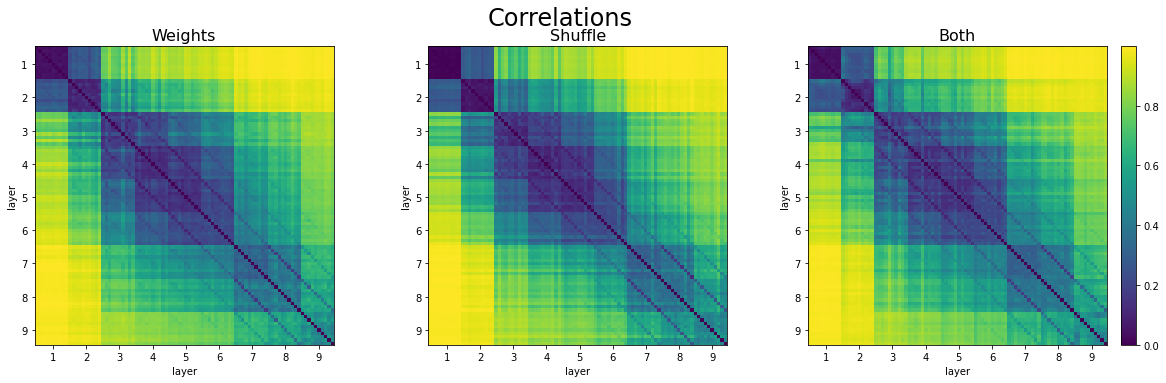

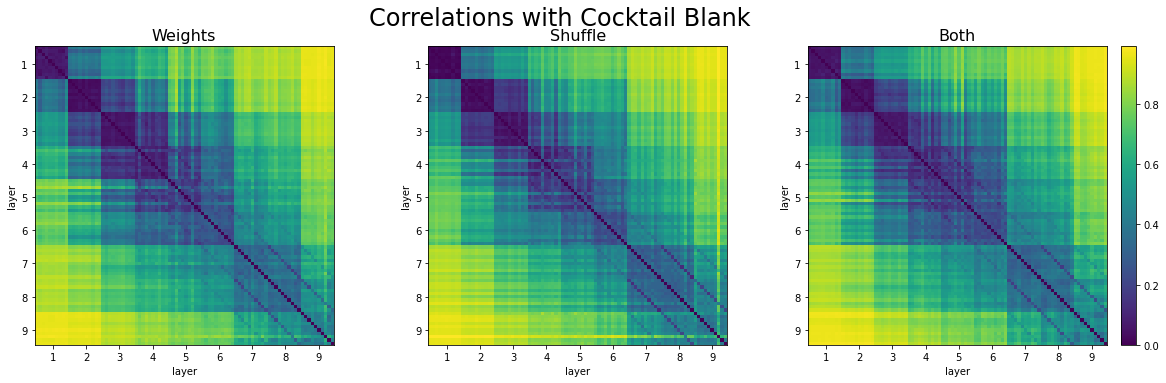

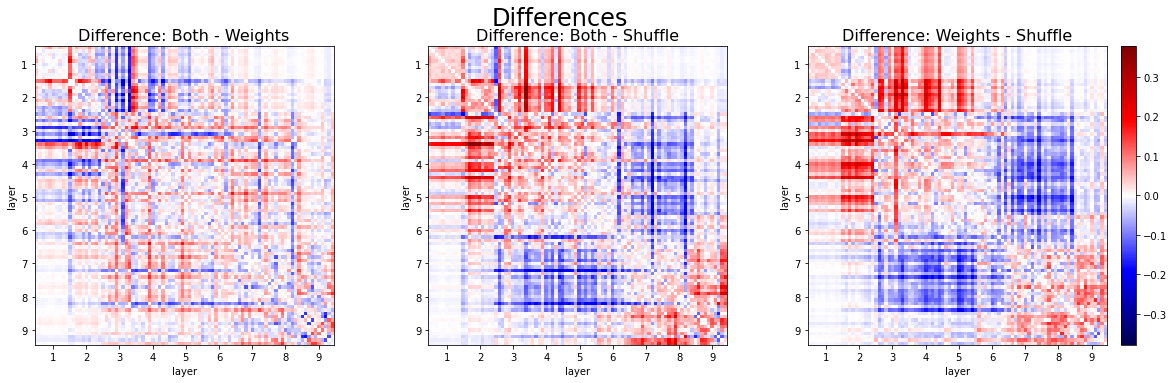

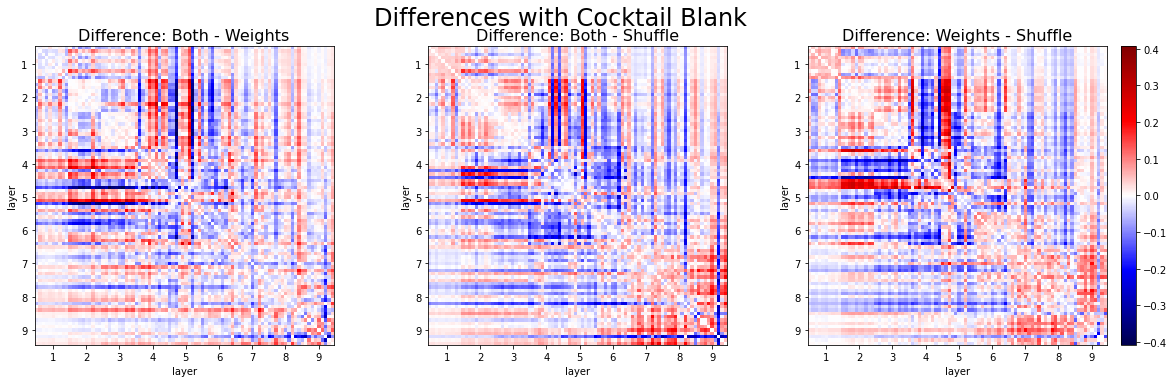

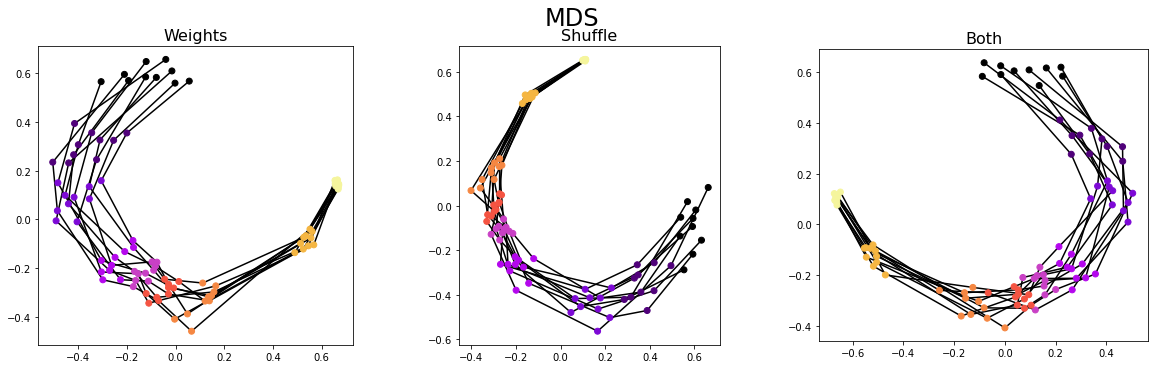

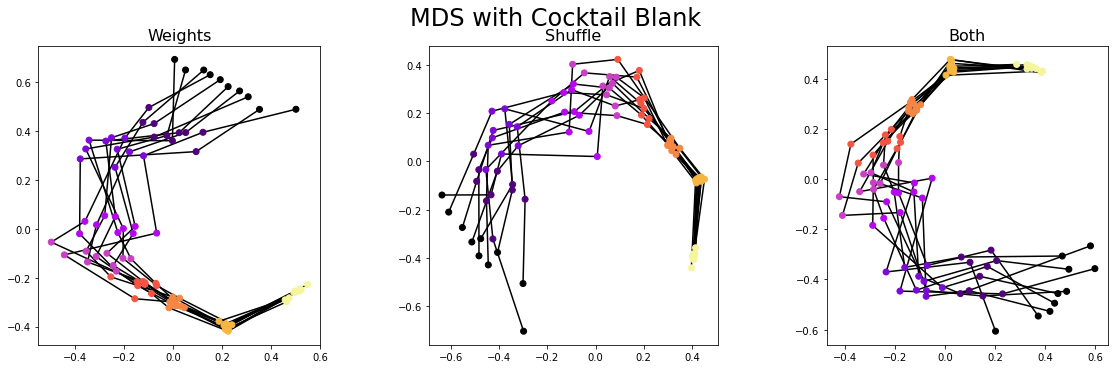

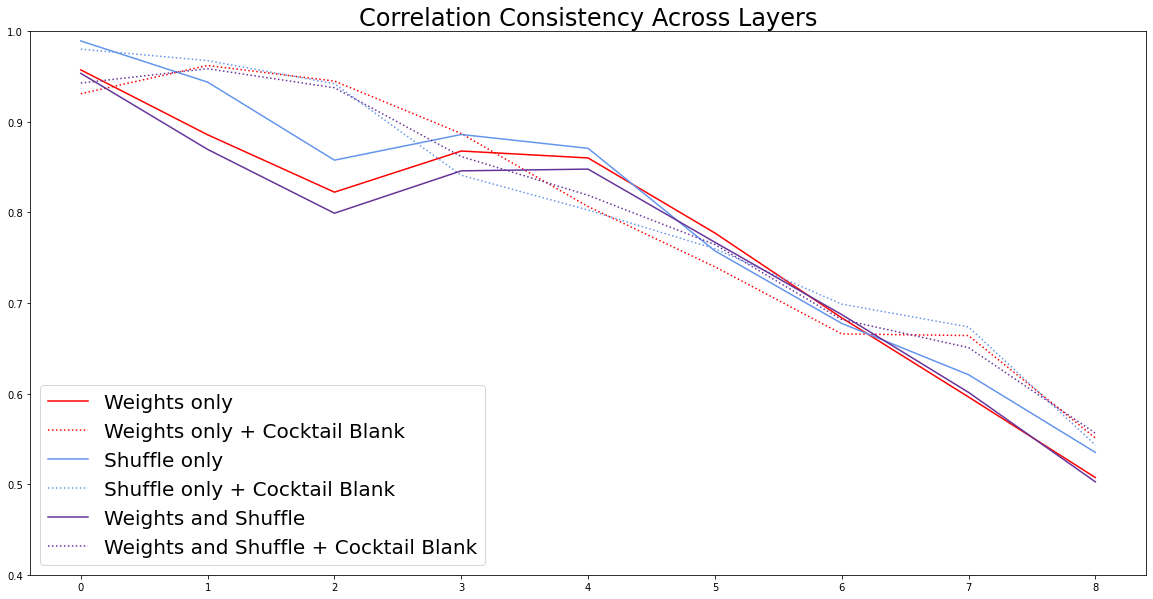

In [199]:
'''
RSA
'''
plot_triple_color(weights=rsa_weights, shuffle=rsa_shuffle, both=rsa_both, title='Correlations')
plot_triple_color(weights=rsa_weights_cb, shuffle=rsa_shuffle_cb, both=rsa_both_cb,
                  title='Correlations with Cocktail Blank')
plot_triple_diff(weights=rsa_weights, shuffle=rsa_shuffle, both=rsa_both, title='Differences')
plot_triple_diff(weights=rsa_weights_cb, shuffle=rsa_shuffle_cb, both=rsa_both_cb,
                 title='Differences with Cocktail Blank')
plot_triple_mds(weights=rsa_weights, shuffle=rsa_shuffle, both=rsa_both, title='MDS')
plot_triple_mds(weights=rsa_weights_cb, shuffle=rsa_shuffle_cb, both=rsa_both_cb,
                title='MDS with Cocktail Blank')
plot_consistency(rsa_weights, rsa_weights_cb,
                 rsa_shuffle, rsa_shuffle_cb,
                 rsa_both, rsa_both_cb)

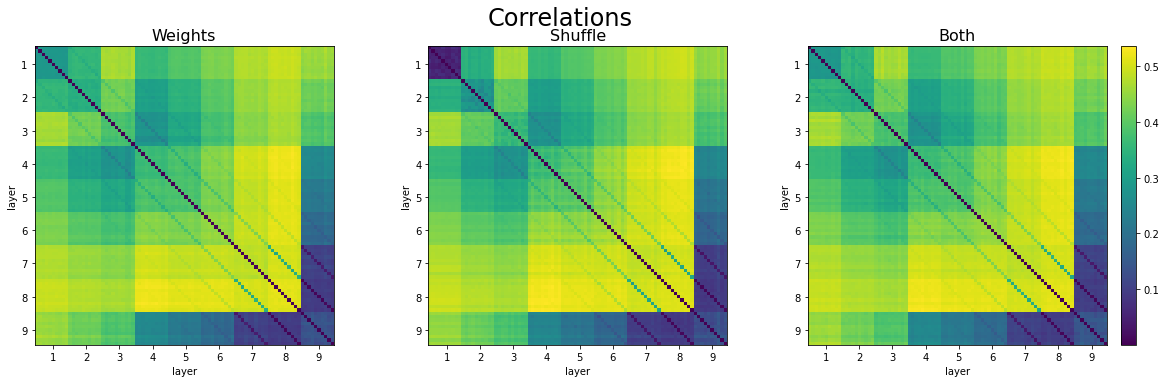

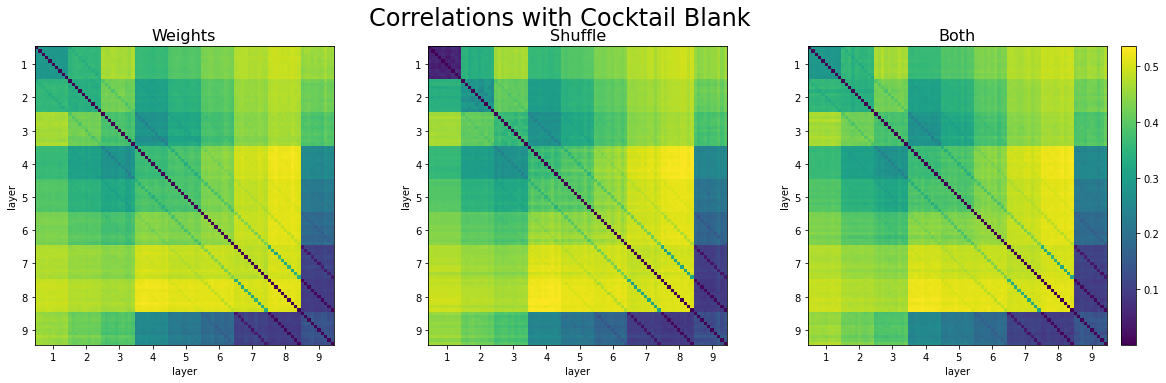

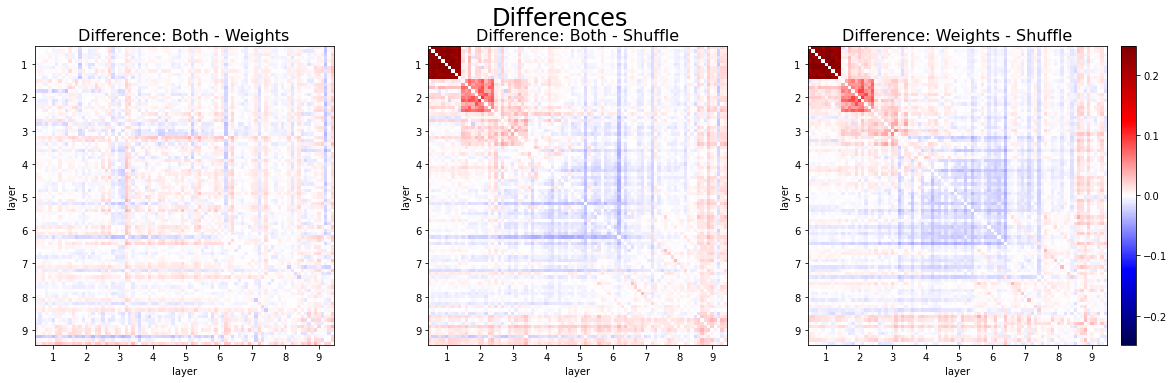

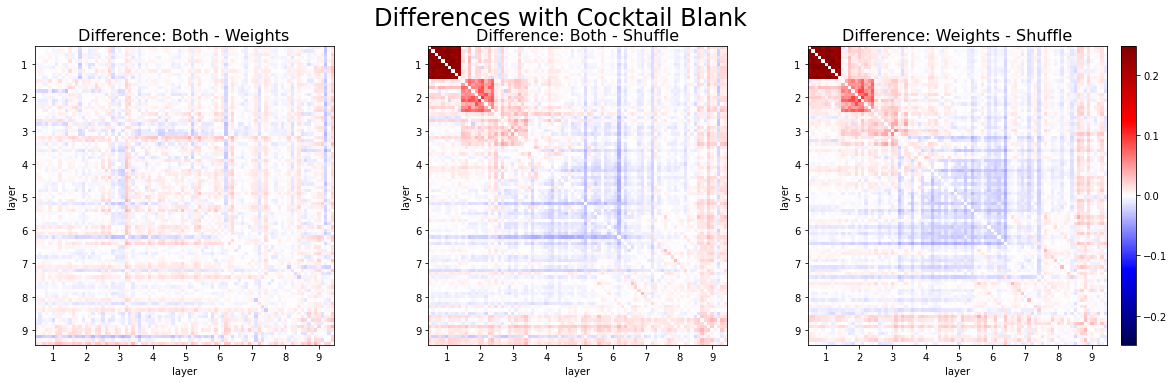

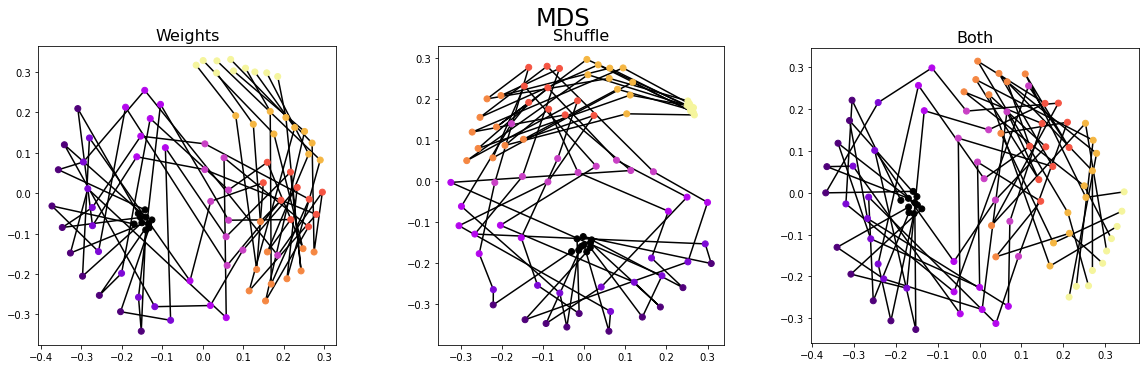

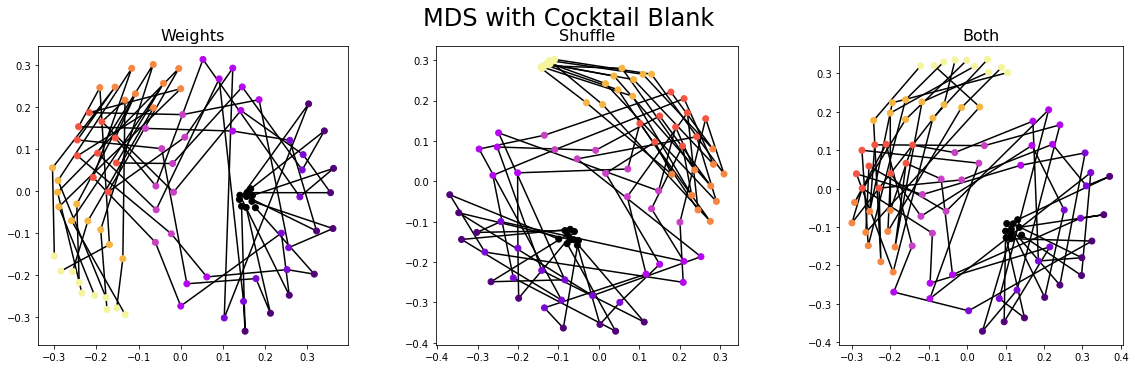

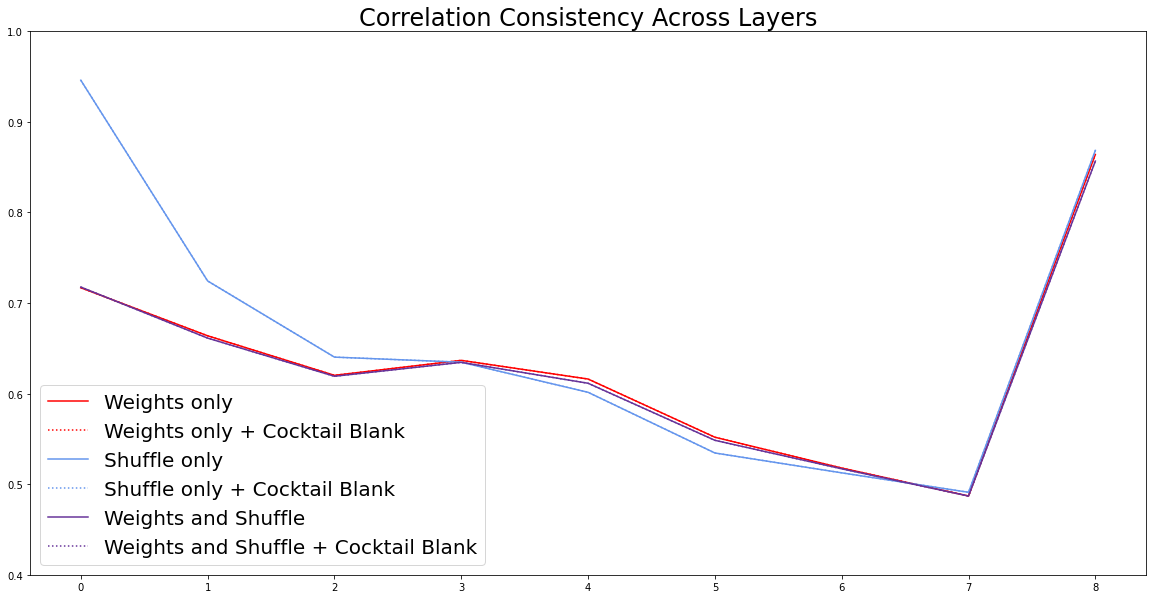

In [200]:
'''
SVCCA
'''
plot_triple_color(weights=svcca_weights, shuffle=svcca_shuffle, both=svcca_both, title='Correlations')
plot_triple_color(weights=svcca_weights_cb, shuffle=svcca_shuffle_cb, both=svcca_both_cb,
                  title='Correlations with Cocktail Blank')
plot_triple_diff(weights=svcca_weights, shuffle=svcca_shuffle, both=svcca_both, title='Differences')
plot_triple_diff(weights=svcca_weights_cb, shuffle=svcca_shuffle_cb, both=svcca_both_cb,
                 title='Differences with Cocktail Blank')
plot_triple_mds(weights=svcca_weights, shuffle=svcca_shuffle, both=svcca_both, title='MDS')
plot_triple_mds(weights=svcca_weights_cb, shuffle=svcca_shuffle_cb, both=svcca_both_cb,
                title='MDS with Cocktail Blank')
plot_consistency(svcca_weights, svcca_weights_cb,
                 svcca_shuffle, svcca_shuffle_cb,
                 svcca_both, svcca_both_cb)

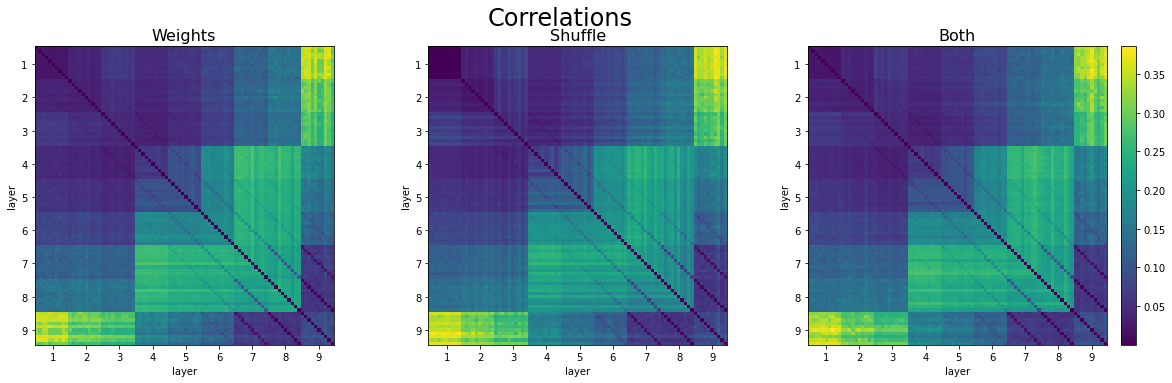

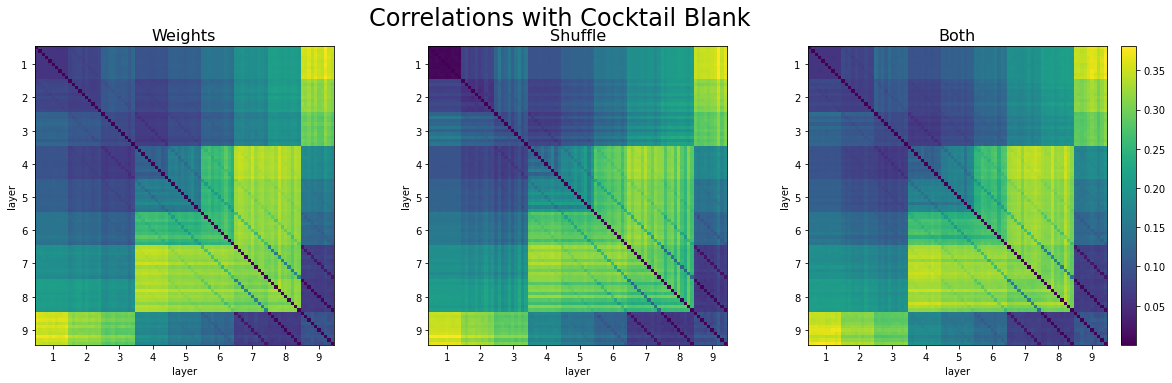

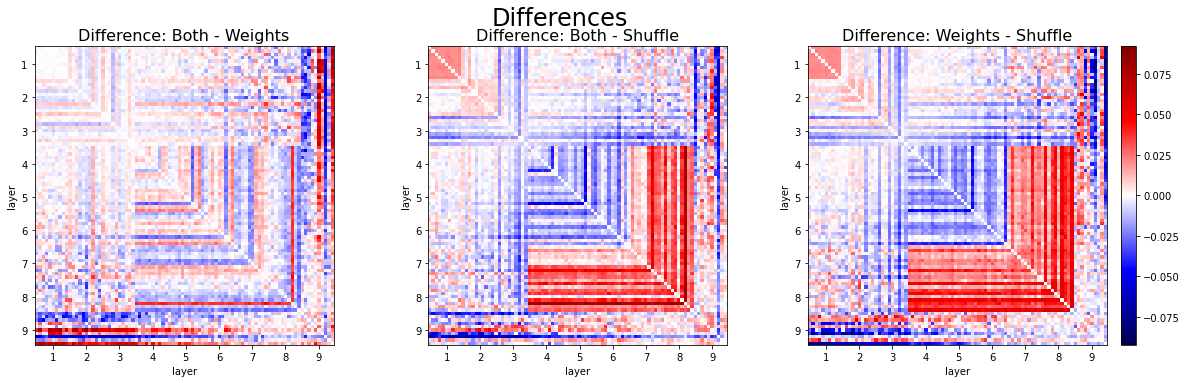

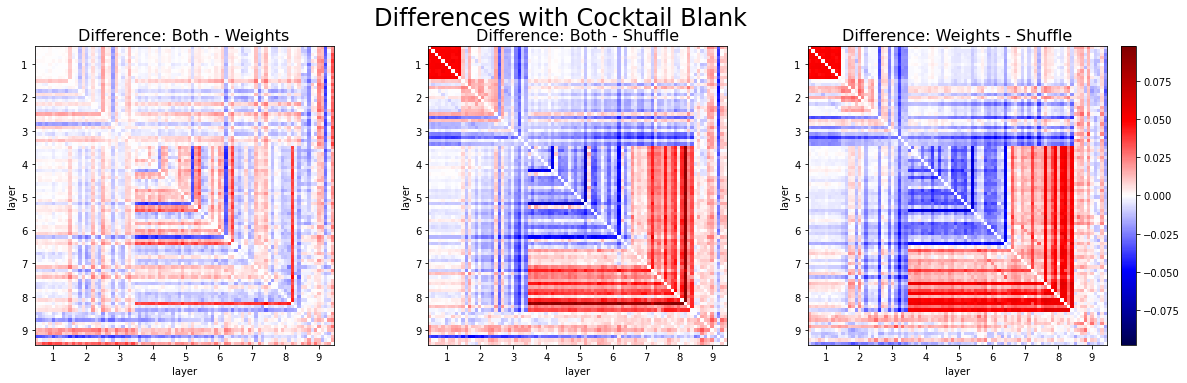

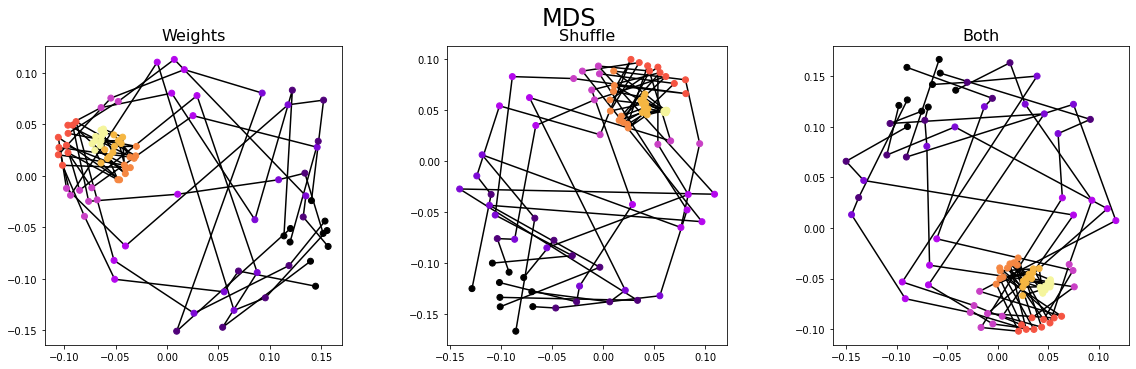

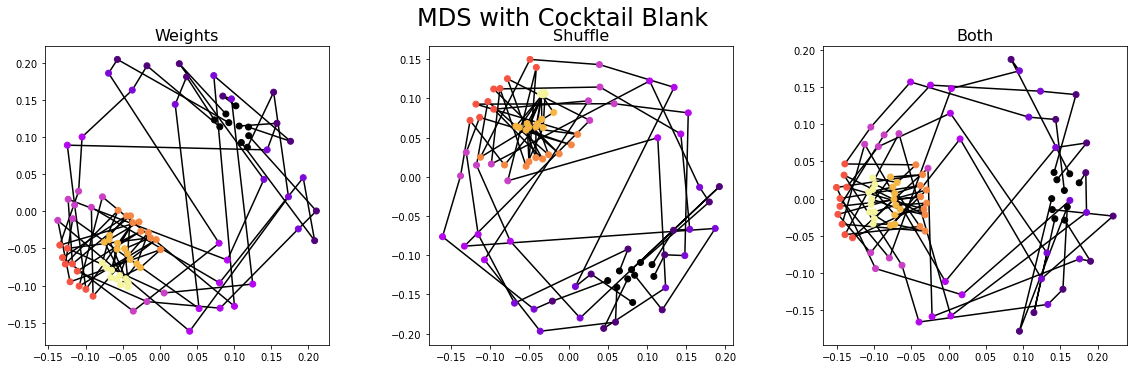

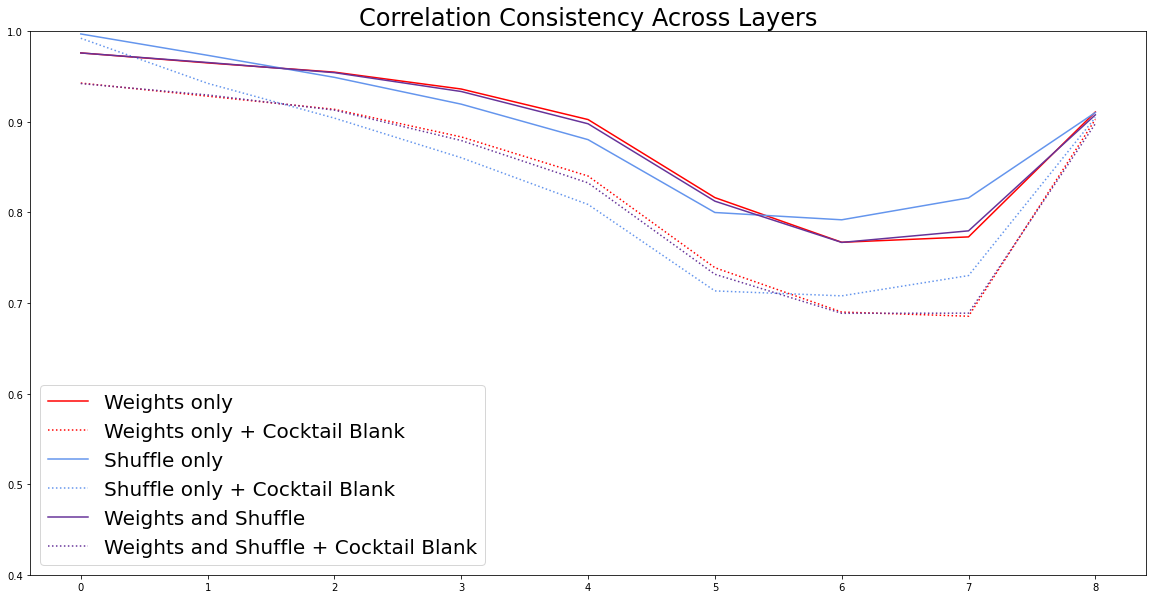

In [201]:
'''
PWCCA
'''
plot_triple_color(weights=pwcca_weights, shuffle=pwcca_shuffle, both=pwcca_both, title='Correlations')
plot_triple_color(weights=pwcca_weights_cb, shuffle=pwcca_shuffle_cb, both=pwcca_both_cb,
                  title='Correlations with Cocktail Blank')
plot_triple_diff(weights=pwcca_weights, shuffle=pwcca_shuffle, both=pwcca_both, title='Differences')
plot_triple_diff(weights=pwcca_weights_cb, shuffle=pwcca_shuffle_cb, both=pwcca_both_cb,
                 title='Differences with Cocktail Blank')
plot_triple_mds(weights=pwcca_weights, shuffle=pwcca_shuffle, both=pwcca_both, title='MDS')
plot_triple_mds(weights=pwcca_weights_cb, shuffle=pwcca_shuffle_cb, both=pwcca_both_cb,
                title='MDS with Cocktail Blank')
plot_consistency(pwcca_weights, pwcca_weights_cb,
                 pwcca_shuffle, pwcca_shuffle_cb,
                 pwcca_both, pwcca_both_cb)

## Key findings thus far
- Overall, shuffle by itself appears to produce the most variance, demonstrated by a blurrier blocking structure in RSA and more striations in PWCCA
- Weights seem to overpower shuffle when varied together, so weights + shuffle ends up looking very similar to weights alone across all 3 correlation techniques
- This overpowering gets to the point where sometimes combining weights and shuffle creates *less* variance
- Outside of striations caused by the different alignment of outliers, these weight+shuffle anomalies seem to concentrate in the pooling layers (layers 3 and 6). See first RSA diff graph and 2nd+3rd PWCCA diff graphs
- Weights seems to create more variance in early layers (especially visible in SVCCA), while shuffle creates more variance in later laters, but weights again takes precedence in the last layer
- Utilizing multiple analysis techniques generates more insights than just one
- Cocktail blank results in less of a distinction between weights and shuffle
- Non-CB RSA rep cons highlights first pooling layer, CB RSA rep cons highlights second
- CB has opposite effect on PWCCA, no effect on SVCCA


In [64]:
acts = analysis.get_acts(load_model('../outputs/models/primary/instance_200.h5'),
                         range(9), x_predict, cocktail_blank=False)

Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...


In [69]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
num_imgs, h, w, channels = acts[0].shape
rdm = analysis.get_rdm(acts[0].reshape(num_imgs, h*w*channels))
X_transformed = embedding.fit_transform(rdm)
print(X_transformed.shape)

shape: (1000, 98304)
num_images = 1000
(1000, 2)


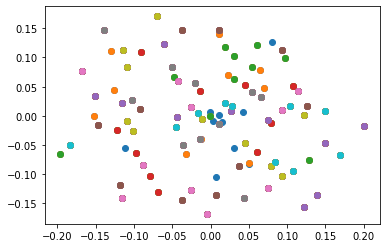

In [76]:
for i in range(10):
    plt.scatter(X_transformed[i*100 :: 10, 0], X_transformed[i*100 :: 10, 1])
plt.show()

shape: (1000, 360)
num_images = 1000
(1000, 2)


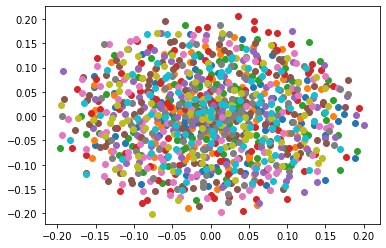

In [71]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
num_imgs, h, w, channels = acts[8].shape
rdm = analysis.get_rdm(acts[8].reshape(num_imgs, h*w*channels))
X_transformed = embedding.fit_transform(rdm)
print(X_transformed.shape)
for i in range(10):
    plt.scatter(X_transformed[i*100 : (i+1)*100, 0], X_transformed[i*100 : (i+1)*100, 1])
plt.show()

In [9]:
'''
Visualize Transfrom Baseline
'''

color_rsa_weights = baseline.transform_baseline(x_predict, 'color', 
                                       load_model('../outputs/models/primary/instance_200.h5'),
                                       7, analysis.do_rsa)

### Transform: color with do_rsa
 - Working on version 0 of 201
 - Now correlating...
correlation: 0.23913300431509568
 - Working on version 1 of 201
 - Now correlating...
correlation: 0.23931251451616414
 - Working on version 2 of 201
 - Now correlating...
correlation: 0.23948889841570284
 - Working on version 3 of 201
 - Now correlating...
correlation: 0.23968544303099737
 - Working on version 4 of 201
 - Now correlating...
correlation: 0.2398418176616428
 - Working on version 5 of 201
 - Now correlating...
correlation: 0.23995322286726917
 - Working on version 6 of 201
 - Now correlating...
correlation: 0.24011745982869434
 - Working on version 7 of 201
 - Now correlating...
correlation: 0.24045542830324787
 - Working on version 8 of 201
 - Now correlating...
correlation: 0.24058463253167844
 - Working on version 9 of 201
 - Now correlating...
correlation: 0.2407654614785865
 - Working on version 10 of 201
 - Now correlating...
correlation: 0.2409011030694957
 - Working on version 1

 - Now correlating...
correlation: 0.24703539778688083
 - Working on version 95 of 201
 - Now correlating...
correlation: 0.24709470951363213
 - Working on version 96 of 201
 - Now correlating...
correlation: 0.2470518147754372
 - Working on version 97 of 201
 - Now correlating...
correlation: 0.24721693659091193
 - Working on version 98 of 201
 - Now correlating...
correlation: 0.24720062337038998
 - Working on version 99 of 201
 - Now correlating...
correlation: 0.24715751452481396
 - Working on version 100 of 201
 - Now correlating...
correlation: 0.24713889282443777
 - Working on version 101 of 201
 - Now correlating...
correlation: 0.24710292160253106
 - Working on version 102 of 201
 - Now correlating...
correlation: 0.247209491267949
 - Working on version 103 of 201
 - Now correlating...
correlation: 0.2472666305989212
 - Working on version 104 of 201
 - Now correlating...
correlation: 0.24724494181360435
 - Working on version 105 of 201
 - Now correlating...
correlation: 0.2471

 - Now correlating...
correlation: 0.24478387822497108
 - Working on version 189 of 201
 - Now correlating...
correlation: 0.24463627647248923
 - Working on version 190 of 201
 - Now correlating...
correlation: 0.2445811350211949
 - Working on version 191 of 201
 - Now correlating...
correlation: 0.2445941645409088
 - Working on version 192 of 201
 - Now correlating...
correlation: 0.2445873949392493
 - Working on version 193 of 201
 - Now correlating...
correlation: 0.24455901199439628
 - Working on version 194 of 201
 - Now correlating...
correlation: 0.24446633392917186
 - Working on version 195 of 201
 - Now correlating...
correlation: 0.24444323589629552
 - Working on version 196 of 201
 - Now correlating...
correlation: 0.24434248468126515
 - Working on version 197 of 201
 - Now correlating...
correlation: 0.24427841539837258
 - Working on version 198 of 201
 - Now correlating...
correlation: 0.24436756029540485
 - Working on version 199 of 201
 - Now correlating...
correlation: 

In [107]:
'''
Save weights
'''
# np.save('pwcca_weights.npy', pwcca_weights)
# np.save('pwcca_shuffle.npy', pwcca_shuffle)
# np.save('svcca_weights.npy', svcca_weights)
# np.save('svcca_shuffle.npy', svcca_shuffle)
# np.save('rsa_weights.npy', rsa_weights)
# np.save('rsa_shuffle.npy', rsa_shuffle)
# np.save('rsa_both.npy', rsa_both)
# np.save('pwcca_both.npy', pwcca_both)
# np.save('svcca_both.npy', svcca_both)
pwcca_weights = np.load('pwcca_weights.npy')
svcca_weights = np.load('svcca_weights.npy')
rsa_weights = np.load('rsa_weights.npy')
pwcca_shuffle = np.load('pwcca_shuffle.npy')
svcca_shuffle = np.load('svcca_shuffle.npy')
rsa_shuffle = np.load('rsa_shuffle.npy')
pwcca_both = np.load('pwcca_both.npy')
svcca_both = np.load('svcca_both.npy')
rsa_both = np.load('rsa_both.npy')


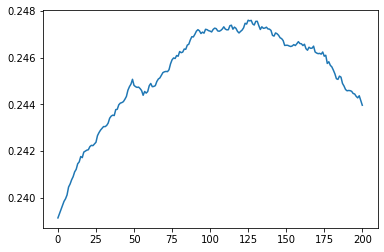

In [10]:
plt.plot(color_rsa_weights)